<h2 style="background-color:#697a89;color:white;padding:0px;line-height: 2em;">Cars4U - Pre-owned car sales analysis and predictive model creation</h2>

<H2>Background & Context</H2>

There is a huge demand for used cars in the Indian Market today. As sales of new cars have slowed down in the recent past, the pre-owned car market has continued to grow over the past years and is larger than the new car market now. Cars4U is a budding tech start-up that aims to find footholes in this market.

In 2018-19, while new car sales were recorded at 3.6 million units, around 4 million second-hand cars were bought and sold. There is a slowdown in new car sales and that could mean that the demand is shifting towards the pre-owned market. In fact, some car sellers replace their old cars with pre-owned cars instead of buying new ones. Unlike new cars, where price and supply are fairly deterministic and managed by OEMs (Original Equipment Manufacturer / except for dealership level discounts which come into play only in the last stage of the customer journey), used cars are very different beasts with huge uncertainty in both pricing and supply. Keeping this in mind, the pricing scheme of these used cars becomes important in order to grow in the market.

As a senior data scientist at Cars4U, you have to come up with a pricing model that can effectively predict the price of used cars and can help the business in devising profitable strategies using differential pricing. For example, if the business knows the market price, it will never sell anything below it. 

<H2>Objective</H2>

Explore and visualize the dataset.
Build a linear regression model to predict the prices of used cars.
Generate a set of insights and recommendations that will help the business.
    
Data Dictionary
    
* S.No. : Serial Number
* Name : Name of the car which includes Brand name and Model name
* Location : The location in which the car is being sold or is available for purchase Cities
* Year : Manufacturing year of the car
* Kilometers_driven : The total kilometers driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner : Type of ownership
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model in INR Lakhs.(1 Lakh = 100, 000)
* Price : The price of the used car in INR Lakhs (1 Lakh = 100, 000)    

<h2>Importing Libraries</h2>

In [1]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install nb_black
#%load_ext lab_black

In [2]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_object_dtype
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_numeric_dtype

# import visualization libraries

import matplotlib.pyplot as plt
import matplotlib.pyplot as xticks
import matplotlib.ticker as mtick
import seaborn as sns
import pylab

sns.set(style="darkgrid")  # set stype for seaborn charts
palette = sns.color_palette("Paired", 8) # vs "Paired"

# import statistics libraries
import scipy.stats as stats
from scipy.stats import skew
import statsmodels.api as sm
import statistics


# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To enable plotting graphs in Jupyter notebook
%matplotlib inline

# To build linear regression_model
from sklearn.linear_model import LinearRegression

# To check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<h4>Global user defined functions and constants</h4>

In [3]:
###############################################################
# Global variables and constant literals used in this notebook
###############################################################
def constant(f):
    def fset(self, value):
        raise TypeError

    def fget(self):
        return f()

    return property(fget, fset)


class _Constant(object):
    @constant
    def significance_level():
        return 0.05

    # def add additional consts here


const = _Constant()

###############################################################
# Global user defined functions
###############################################################

# Function to enhance plots with percentage
def bar_plot_with_perc(plot, feature):
    total = len(feature)  # length of the column
    for p in plot.patches:
        x = p.get_x() + p.get_width() / 2 - 0.05  # width
        y = p.get_y() + p.get_height()  # height
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage for each slice of the category
        plot.annotate(percentage, (x, y), size=12)  # add the percentage label
    plt.show()


# Section Global functions def
def show_missing_data(df):
    total_nulls = (
        df.isnull().sum().sort_values(ascending=False)
    )  # total number of null values
    total_count = df.count()
    percent = (total_nulls / total_count).sort_values(
        ascending=False
    )  # percentage of values that are null
    missing_data = pd.concat(
        [total_nulls, total_count, percent],
        axis=1,
        keys=["Total Nulls", "Total Rows", "% Null"],
    )  # putting the above two together
    return missing_data  # return the dataframe


# Simple Histogram
def histogram_simple(feature, figsize=(12, 8), title=None):

    if title == None:
        title = "Univariate Analysis for " + feature.name.upper()

    plt.figure(figsize=figsize)
    mean = feature.mean()
    median = feature.median()
    ax = sns.distplot(
        feature,
        rug=True,
        rug_kws={"color": "b"},
        kde_kws={"color": "k", "lw": 1, "label": "KDE"},
        hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "b"},
    )
    ax.set_title(title)
    ax.axvline(
        mean, color="green", linestyle="--", linewidth=2
    )  # Add mean to the histogram
    ax.axvline(
        median, color="black", linestyle="-", linewidth=2
    )  # Add median to the histogram

    plt.legend({"Mean": mean, "Median": median})
    plt.show()


# Histogram/Boxplot combo
def histogram_boxplot(feature, figsize=(12, 8), bins=None):
    # Boxplot and histogram combined
    # feature: 1-d feature array
    # figsize: size of fig default (12,8)
    # bins: number of bins (default None / auto)

    # While doing uni-variate analysis of numerical variables we want to study their central tendency
    # and dispersion.This function takes the numerical column as the input and returns the boxplots
    # and histograms for the variable.

    mean = feature.mean()
    median = feature.median()
    mode = feature.mode().tolist()[0]
    quantile25 = feature.quantile(q=0.25)
    quantile75 = feature.quantile(q=0.75)

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        ncols=1,  # number of cols
        # sharex = True, # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots

    f2.suptitle(
        "Univariate Analysis for " + feature.name.upper(),
        fontsize=16,
        fontweight="bold",
    )
    # Render box plot
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, orient="h", color="#F14848"
    )  # boxplot will be created and a star will indicate the mean value of the column
    ax_box2.set(xlabel="")

    # Render dist plot, for histogram
    sns.distplot(
        feature,
        kde=False,
        label="kde",
        color="#1A6BD7",
        ax=ax_hist2,
        bins=bins,
        rug=True,
    ) if bins else sns.distplot(
        feature,
        kde=True,
        label="kde",
        color="#1A6BD7",
        ax=ax_hist2,
        rug=True,
    )

    ax_hist2.axvline(
        mean, label="Mean", color="green", linestyle="--", linewidth=2
    )  # Add mean to the histogram
    ax_hist2.axvline(
        median, label="Median", color="black", linestyle="-", linewidth=1
    )  # Add median to the histogram
    ax_hist2.axvline(
        mode, label="Mode", color="yellow", linestyle="dotted", linewidth=1
    )  # Add quantile 25% to the histogram
#     ax_hist2.axvline(
#         quantile25, label="25% Quantile", color="blue", linestyle="--", linewidth=2
#     )  # Add quantile 75% to the histogram
#     ax_hist2.axvline(
#         quantile75, label="75% Quantile", color="blue", linestyle="--", linewidth=2
#     )  # Add mode to the histogram
    ax_hist2.legend()

    plt.show()


# determine the skewness in the variables
def skewed_features(data):
    # select_dtypes()- returns a subset of the dataframe based on the data types that are 
    # provided in the 'include' parameter.
    numerical_features = data[
        data.select_dtypes(include=np.number).columns.tolist()
    ]  # data[const.vars_numeric_all]
    skewed_features = numerical_features.apply(lambda x: skew(x.dropna())).sort_values(
        ascending=False
    )
    return skewed_features


# determine IQR in a dataframe series
def iqr(df, colname):
    q_75, q_25 = np.percentile(df[colname], [75, 25])
    return q_75 - q_25


# Treat outliers by flooring and capping
def treat_outliers(df, col):
    """
    treats outliers in a variable
    col: str, name of the numerical variable
    df: dataframe
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df


# defining function for MAPE
def mape(targets, predictions):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# defining common function for all metrics
def model_perf(model, inp, out):
    """
    model: model
    inp: independent variables
    out: dependent variable
    """
    y_pred = model.predict(inp).flatten()
    y_act = out.values.flatten()

    return pd.DataFrame(
        {
            "MAE": mean_absolute_error(y_act, y_pred),
            "MAPE": mape(y_act, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_act, y_pred)),
            "R^2": r2_score(y_act, y_pred),
            "AR^2": 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1) #needs linearregression module    
        },
        index=[0],
    )
def model_perf_OLS(model, inp, out):
    """
    model: model
    inp: independent variables
    out: dependent variable
    """
    y_pred = model.predict(inp).flatten()
    y_act = out.values.flatten()

    return pd.DataFrame(
        {
            "MAE": mean_absolute_error(y_act, y_pred),
            "MAPE": mape(y_act, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_act, y_pred)),
            "R^2": r2_score(y_act, y_pred),
            "AR^2": model.rsquared_adj  #needs OLS statsmodule       
        },
        index=[0],
    )


# returns the non-numerical vars in a df
def get_vars_non_numerical(df):
    cols = []
    for colname in df.columns:
        if not is_numeric_dtype(df[colname]):
            cols.append(colname)
    return cols


# returns the numerical vars in a df
def get_vars_numerical(df):
    cols = []
    for colname in df.columns:
        if is_numeric_dtype(df[colname]):
            cols.append(colname)
    return cols

def cars4u_show_dist_qq(df,title):
    # Check value distributions for Price, Power, Seats, Engine and Mileage to apply the 
    # most appropriate central tendency measure.
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(14, 4), sharex=False)

    # Distribution Plot
    sns.distplot(df['Kilometers_Driven'], color="b", ax=ax1)
    sns.distplot(df['Price'], color="m", ax=ax2)
    sns.distplot(df['Power'], color="r", ax=ax3)
    sns.distplot(df['Engine'], color="g", ax=ax4)

    plt.suptitle(title,fontsize=16,fontweight="bold")

    plt.tight_layout()
    plt_grid = plt.GridSpec(1,4)

    ### QQ Plot

    plt.subplots(figsize=(14, 4), sharex=False)

    ax00= plt.subplot(plt_grid[0,0])
    measurements = df["Kilometers_Driven"]
    stats.probplot(measurements, dist="norm", plot=pylab)

    ax01= plt.subplot(plt_grid[0,1])
    measurements = df["Price"]
    stats.probplot(measurements, dist="norm", plot=pylab)

    ax02= plt.subplot(plt_grid[0,2])
    measurements = df["Power"]
    stats.probplot(measurements, dist="norm", plot=pylab)

    ax03= plt.subplot(plt_grid[0,3])
    measurements = df["Engine"]
    stats.probplot(measurements, dist="norm", plot=pylab)

    plt.tight_layout();

In [4]:
# Load the data into pandas dataframe
cars4u_data = pd.read_csv("used_cars_data.csv")

In [5]:
# Creating a copy for the original data.
df = cars4u_data.copy()

<H2>Data Structure Overview </H2>

In [6]:
np.random.seed(1)  # setting a seed of 1 so I will get the same results everytime
df.sample(n=10)  # get a random sample with 15 rows

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
2397,2397,Ford EcoSport 1.5 Petrol Trend,Kolkata,2016,21460,Petrol,Manual,First,17.0 kmpl,1497 CC,121.36 bhp,5.0,9.47 Lakh,6.00
3777,3777,Maruti Wagon R VXI 1.2,Kochi,2015,49818,Petrol,Manual,First,21.5 kmpl,1197 CC,81.80 bhp,5.0,5.44 Lakh,4.11
4425,4425,Ford Endeavour 4x2 XLT,Hyderabad,2007,130000,Diesel,Manual,First,13.1 kmpl,2499 CC,141 bhp,7.0,NaN,6.00
3661,3661,Mercedes-Benz E-Class E250 CDI Avantgrade,Coimbatore,2016,39753,Diesel,Automatic,First,13.0 kmpl,2143 CC,201.1 bhp,5.0,NaN,35.28
4514,4514,Hyundai Xcent 1.2 Kappa AT SX Option,Kochi,2016,45560,Petrol,Automatic,First,16.9 kmpl,1197 CC,82 bhp,5.0,NaN,6.34
599,599,Toyota Innova Crysta 2.8 ZX AT,Coimbatore,2019,40674,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,7.0,28.05 Lakh,24.82
186,186,Mercedes-Benz E-Class E250 CDI Avantgrade,Bangalore,2014,37382,Diesel,Automatic,First,13.0 kmpl,2143 CC,201.1 bhp,5.0,NaN,32.00
305,305,Audi A6 2011-2015 2.0 TDI Premium Plus,Kochi,2014,61726,Diesel,Automatic,First,17.68 kmpl,1968 CC,174.33 bhp,5.0,NaN,20.77
4582,4582,Hyundai i20 1.2 Magna,Kolkata,2011,36000,Petrol,Manual,First,18.5 kmpl,1197 CC,80 bhp,5.0,NaN,2.50
5434,5434,Honda WR-V Edge Edition i-VTEC S,Kochi,2019,13913,Petrol,Manual,First,17.5 kmpl,1199 CC,88.7 bhp,5.0,9.36 Lakh,8.20


<h5>Initial Observations:</h5>

* The Mileage,Engine, Power columns need to be treated as it includes the unit description and needs to be converted into numeric.
* There are a lot of categorical variables to consider.

<h2>Columns Processing</h2>

Cleaning and converting Mileage, Engine, Power to numerical columns.

In [7]:
#This section removes unit chars from the num columns.
cols_to_cleanse = ["Mileage", "Engine", "Power"]


def cleanse_cols(val):   
    if isinstance(val, str): 
        return (
            val.replace("kmpl", "")
            .replace("km/kg", "")
            .replace("CC", "")
            .replace("bhp", "")
            .replace("Lakh", "")
            .replace("null", "")
        )
    else:
        return np.nan


for colname in cols_to_cleanse:
    df[colname] = df[colname].apply(cleanse_cols).str.strip()

df[cols_to_cleanse].sample(n=10)  # Checking

,Mileage,Engine,Power
2245,21.5,1197,81.80
6407,20.4,1197,81.80
1226,14.28,1798,138.03
533,16.8,1497,118
6330,18.6,1197,81.83
5931,16.02,1373,93.7
2784,23.08,1461,63.1
5180,13.7,1798,157.75
2722,21.66,1498,108.62
5322,24.0,1120,70


Converting variables to the appropriate data type.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


* Price and Seats are the most affected with missing values that will need to be dealt with.
* Seats, Power, Engine and Mileage has way less missing values to be taken care of.

In [9]:
# Converting the cleansed cols to numeric/float
for colname in ["Mileage", "Engine", "Power"]:
    df[colname] = pd.to_numeric(df[colname])

# Converting *object* data types into categorical variables

df["Name"] = df["Name"].astype("category")
df["Location"] = df["Location"].astype("category")
df["Fuel_Type"] = df["Fuel_Type"].astype("category")
df["Transmission"] = df["Transmission"].astype("category")
df["Owner_Type"] = df["Owner_Type"].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   S.No.              7253 non-null   int64   
 1   Name               7253 non-null   category
 2   Location           7253 non-null   category
 3   Year               7253 non-null   int64   
 4   Kilometers_Driven  7253 non-null   int64   
 5   Fuel_Type          7253 non-null   category
 6   Transmission       7253 non-null   category
 7   Owner_Type         7253 non-null   category
 8   Mileage            7251 non-null   float64 
 9   Engine             7207 non-null   float64 
 10  Power              7078 non-null   float64 
 11  Seats              7200 non-null   float64 
 12  New_Price          1006 non-null   object  
 13  Price              6019 non-null   float64 
dtypes: category(5), float64(5), int64(3), object(1)
memory usage: 649.4+ KB


* Each variable has now their correct data type. Yay!

<h4>Checking column totals with missing values:</h4>

In [10]:
show_missing_data(df[df.columns[df.isnull().any()]])

,Total Nulls,Total Rows,% Null
New_Price,6247,1006,6.209742
Price,1234,6019,0.205017
Power,175,7078,0.024724
Seats,53,7200,0.007361
Engine,46,7207,0.006383
Mileage,2,7251,0.000276


In [11]:
# New_Price cannot be used and doesn't provide much values as it contains lots of missing. 
# Dropping the New_Price column and S.No., not needed.

df.drop(["New_Price","S.No."], axis=1, inplace=True)

In [12]:
df["Seats"].value_counts()

5.0     6047
7.0      796
8.0      170
4.0      119
6.0       38
2.0       18
10.0       8
9.0        3
0.0        1
Name: Seats, dtype: int64

In [13]:
# Drop the only one car on earth with no seats :--)
dd=df[df["Seats"] > 0]

**Treating car names:**

In [14]:
#Initial check of car name formating:
names = df["Name"].drop_duplicates().sort_values(ascending=True).to_frame()

for car_name in names.head(n=10).iterrows():
    print(car_name[1]["Name"])

for car_name in names.tail(n=10).iterrows():
    print(car_name[1]["Name"])

Ambassador Classic Nova Diesel
Audi A3 35 TDI Attraction
Audi A3 35 TDI Premium
Audi A3 35 TDI Premium Plus
Audi A3 35 TDI Technology
Audi A4 1.8 TFSI
Audi A4 1.8 TFSI Technology Edition
Audi A4 2.0 TDI
Audi A4 2.0 TDI 177 Bhp Premium Plus
Audi A4 2.0 TDI 177 Bhp Technology Edition
Volvo S80 D5
Volvo V40 Cross Country D3
Volvo V40 D3
Volvo V40 D3 R Design
Volvo XC60 D4 SUMMUM
Volvo XC60 D4 Summum
Volvo XC60 D5
Volvo XC60 D5 Inscription
Volvo XC90 2007-2015 D5 AT AWD
Volvo XC90 2007-2015 D5 AWD


In [15]:
# We can grab the Car Make from the car name by spliting the name into parts.
MakeAndModel=df["Name"].str.split(" ", n=2, expand=True)

df["Make"] = df["Name"].str.split(" ", n=1, expand=True)[0]
df["Make_Model"] = MakeAndModel[0]+" "+MakeAndModel[1]

df[["Make","Make_Model"]].sample(n=15).drop_duplicates()

,Make,Make_Model
3123,Tata,Tata Manza
6647,Audi,Audi A6
5579,Maruti,Maruti SX4
1083,Toyota,Toyota Corolla
2961,Honda,Honda Amaze
7155,Mercedes-Benz,Mercedes-Benz New
152,Mercedes-Benz,Mercedes-Benz S
1305,BMW,BMW X1
875,Toyota,Toyota Innova
5593,Hyundai,Hyundai i10


Looks good!

In [16]:
#Fixing this now so it won't cause grief later.
df.loc[df.Make == "Isuzu", "Make"] = "ISUZU"
df[df["Make"]=="ISUZU"]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Make,Make_Model
2900,Isuzu MUX 4WD,Jaipur,2017,34429,Diesel,Automatic,First,13.80,2999.0,174.57,7.0,20.00,ISUZU,Isuzu MUX
3624,ISUZU D-MAX V-Cross 4X4,Coimbatore,2018,20422,Diesel,Manual,First,12.40,2499.0,134.00,5.0,16.09,ISUZU,ISUZU D-MAX
5979,ISUZU D-MAX V-Cross 4X4,Jaipur,2017,25000,Diesel,Manual,First,12.40,2499.0,134.00,5.0,8.00,ISUZU,ISUZU D-MAX
6470,Isuzu MU 7 4x2 HIPACK,Kolkata,2016,45000,Diesel,Manual,First,12.08,2999.0,161.00,7.0,NaN,ISUZU,Isuzu MU
6919,ISUZU D-MAX V-Cross 4X4,Jaipur,2017,290000,Diesel,Manual,First,12.40,2499.0,134.00,5.0,NaN,ISUZU,ISUZU D-MAX


In [17]:
# counting unique values
print(
    "There are",
    len(df["Make"].unique()),
    "unique vehicles brands.",
)

There are 32 unique vehicles brands.


In [18]:
# Moving the Make to the front. 
df.insert(0, "Make", df.pop("Make"))
df.insert(1, "Make_Model", df.pop("Make_Model"))
df.head(1)

,Make,Make_Model,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Maruti Wagon,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6,998.0,58.16,5.0,1.75


In [19]:
# Dropping the Name series. No longer needed.
df.drop(["Name"], axis=1, inplace=True)

**Treating Missing Values**

In [20]:
show_missing_data(df[df.columns[df.isnull().any()]])

,Total Nulls,Total Rows,% Null
Price,1234,6019,0.205017
Power,175,7078,0.024724
Seats,53,7200,0.007361
Engine,46,7207,0.006383
Mileage,2,7251,0.000276


In [21]:
df["Seats"].value_counts()

5.0     6047
7.0      796
8.0      170
4.0      119
6.0       38
2.0       18
10.0       8
9.0        3
0.0        1
Name: Seats, dtype: int64

Cars with no seats are no good and must go! Changing nan so it will be replaced in the next step.

In [22]:
df[df["Seats"]==0]

,Make,Make_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
3999,Audi,Audi A4,Hyderabad,2012,125000,Petrol,Automatic,First,10.5,3197.0,NaN,0.0,18.0


In [23]:
# The vehicle with no seats is being replaced with nan.
df.loc[df.Seats == 0, "Seats"] = np.nan

In [24]:
def fill_in_missing_val(name_value, col_to_check):
    """This function takes in a column with missing values and looks for the first non-nan value to apply."""
    df2 = df[(df.Make_Model == name_value) & (df[col_to_check].notna())]

    if df2.shape[0] > 0:
        return df2.iloc[0][col_to_check]
    else:
        return float("NaN")

# get the distinct vehicle names where values are missing
missing_seats = df[df["Seats"].isna()][["Make_Model"]].drop_duplicates(subset=["Make_Model"])

print(missing_seats)

# iterate through each row of missing data and apply the found matching vehicle data for the cell in question.
for index, row in missing_seats.iterrows():
    df.loc[
        df["Seats"].isna() & (df.Make_Model == row.Make_Model), "Seats"
    ] = fill_in_missing_val(row.Make_Model, "Seats")

          Make_Model
194       Honda City
208     Maruti Swift
229        Ford Figo
749       Land Rover
2096  Hyundai Santro
2264    Toyota Etios
2369   Maruti Estilo
2530           BMW 5
2737    Maruti Wagon
3800  Ford Endeavour
3810      Honda CR-V
3999         Audi A4
4011      Fiat Punto
4604      Honda Jazz
6042     Skoda Laura
6544     Hyundai i20
6633    Mahindra TUV


In [25]:
show_missing_data(df[df.columns[df.isnull().any()]])

,Total Nulls,Total Rows,% Null
Price,1234,6019,0.205017
Power,175,7078,0.024724
Engine,46,7207,0.006383
Seats,3,7250,0.000414
Mileage,2,7251,0.000276


* Found and replaced some vehicles with missing seats

In [26]:
# Since Price is the dependent variable, will drop rows where its value is null.
# Small number of rows to matter when considering losing the independent vars info also nuked in the process.
df = df[df['Price'].notnull()]

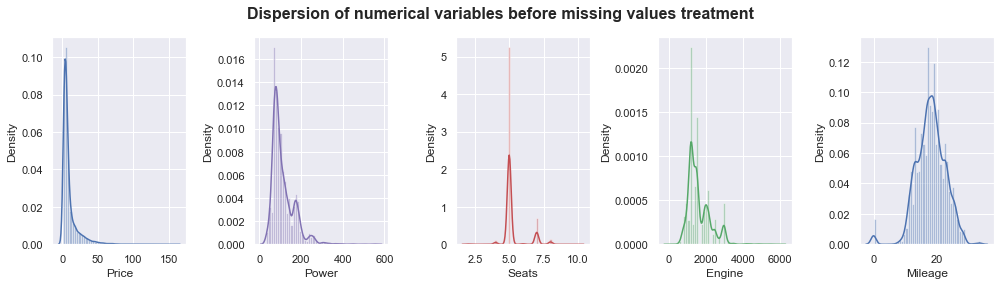

In [27]:
# Check value distributions for Price, Power, Seats, Engine and Mileage to apply the most appropriate central tendency measure.
f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(14, 4), sharex=False)

# Plot a simple distribution of the desired columns
sns.distplot(df['Price'], color="b", ax=ax1)
sns.distplot(df['Power'], color="m", ax=ax2)
sns.distplot(df['Seats'], color="r", ax=ax3)
sns.distplot(df['Engine'], color="g", ax=ax4)
sns.distplot(df['Mileage'], color="b", ax=ax5)

plt.suptitle('Dispersion of numerical variables before missing values treatment',fontsize=16,fontweight="bold")

plt.tight_layout()

In [28]:
print("Median:\n",df[["Price","Power","Seats","Engine","Mileage"]].median())
print("Mean:\n",df[["Price","Power","Seats","Engine","Mileage"]].mean())

Median:
 Price         5.64
Power        97.70
Seats         5.00
Engine     1493.00
Mileage      18.15
dtype: float64
Mean:
 Price         9.479468
Power       113.253050
Seats         5.278092
Engine     1621.276450
Mileage      18.134961
dtype: float64


* It can be observed that the median for each of the numerical variables is appropriated to be used to fill in the missing values, due to the number of outliers on the data.

In [29]:
# Replacing missing values in columns "Power", "Seats","Engine","Mileage" with their median.

cols_nan_to_median = ["Power", "Seats","Engine","Mileage"]
medianFiller = lambda x: x.fillna(x.median())
df[cols_nan_to_median] = df[cols_nan_to_median].apply(medianFiller, axis=0)

#Another option to check is to group by Make+Model and apply the median, but did not noticed any gain in R^2 score.
#df["Price"] = df.groupby(["Make_Model"])["Price"].apply(medianFiller)
#df["Power"] = df.groupby(["Make_Model"])["Power"].apply(medianFiller)
#df["Engine"] = df.groupby(["Make_Model"])["Engine"].apply(medianFiller)

In [30]:
show_missing_data(df)

,Total Nulls,Total Rows,% Null
Price,0,6019,0.0
Seats,0,6019,0.0
Power,0,6019,0.0
Engine,0,6019,0.0
Mileage,0,6019,0.0
Owner_Type,0,6019,0.0
Transmission,0,6019,0.0
Fuel_Type,0,6019,0.0
Kilometers_Driven,0,6019,0.0
Year,0,6019,0.0


* All good. No nulls left to deal with! Let's move on to EDA.

<H2>EDA</H2>

<H3>Univariate Data Analysis</H3>

In [31]:
# Describe the numerical variables, transposed for better visualization.
df[get_vars_numerical].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,6019.0,2013.358199,3.269742,1998.00,2011.00,2014.00,2016.00,2019.00
Kilometers_Driven,6019.0,58738.380296,91268.843206,171.00,34000.00,53000.00,73000.00,6500000.00
Mileage,6019.0,18.134966,4.581528,0.00,15.17,18.15,21.10,33.54
Engine,6019.0,1620.509221,599.635458,72.00,1198.00,1493.00,1969.00,5998.00
Power,6019.0,112.883539,53.283701,34.20,78.00,97.70,138.03,560.00
Seats,6019.0,5.277953,0.803778,2.00,5.00,5.00,5.00,10.00
Price,6019.0,9.479468,11.187917,0.44,3.50,5.64,9.95,160.00


* Note the outliers in Kilometers driven that needs to be dealt with.

In [32]:
# Describe categorical variables.
df[get_vars_non_numerical].describe().transpose()

,count,unique,top,freq
Make,6019,30,Maruti,1211
Make_Model,6019,216,Maruti Swift,353
Location,6019,11,Mumbai,790
Fuel_Type,6019,5,Diesel,3205
Transmission,6019,2,Manual,4299
Owner_Type,6019,4,First,4929


In [33]:
skewed_features(df)

Kilometers_Driven    58.710026
Price                 3.334401
Power                 1.953635
Seats                 1.908501
Engine                1.428585
Mileage              -0.431710
Year                 -0.845591
dtype: float64

* Kilometers_Driven is highly skewed as observed

<h3>Central Tendency and Dispersion of numerical variables</h3>

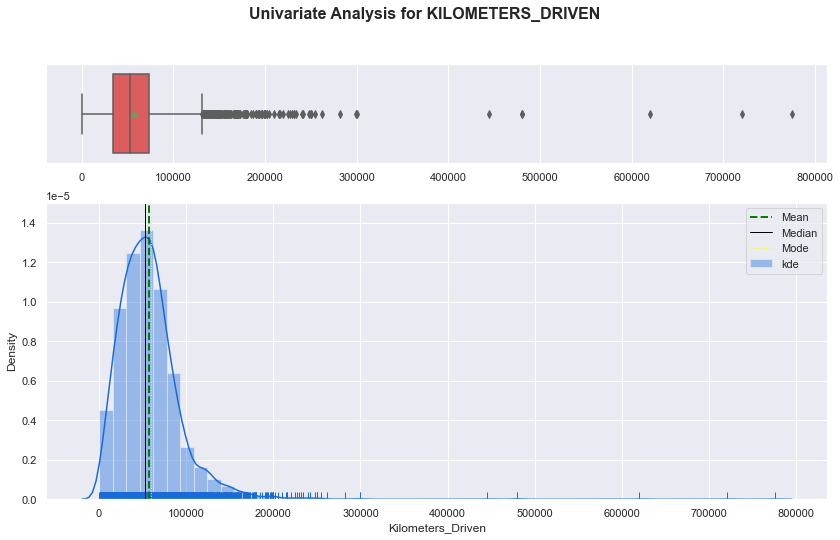

In [34]:
#Removing this outliers observed in the data.
histogram_boxplot(df[df.Kilometers_Driven != 6500000].Kilometers_Driven, figsize=(14, 8))
#print(statistics.median(df.Kilometers_Driven))
#print(statistics.mean(df.Kilometers_Driven))

**Observations**
* Kilometers driven is highly skewed to the right, meaning a pre-ownew vehicle can always be sold no matter many miles it has.
* The mean and median mileage in a used vehicle sold is 58,738 and 53,000 Km respectively.

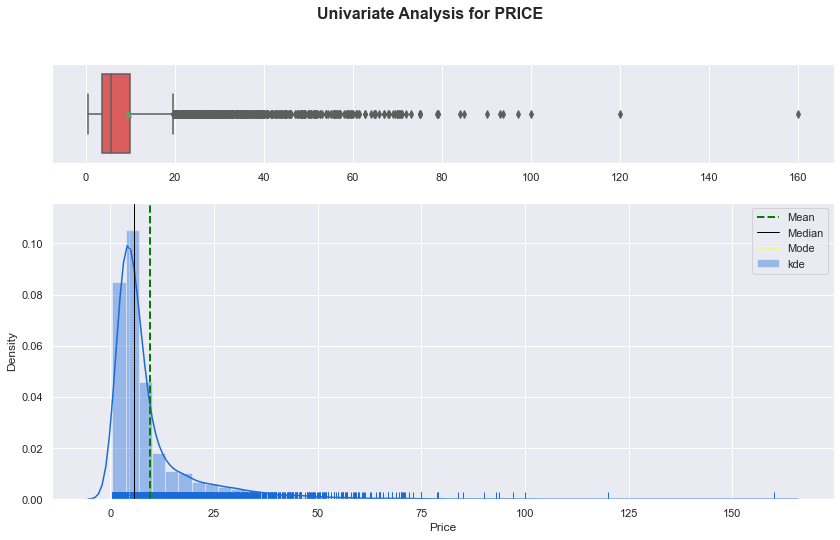

In [35]:
histogram_boxplot(df.Price, figsize=(14, 8))

**Observations**
* Price shows some left skewness, with lots of outliers.
* It is very clear that most customers tend to purchase less expensive vehicles.
* Luxury vehicles appear to be concentrated in a lower percentage of buyers.

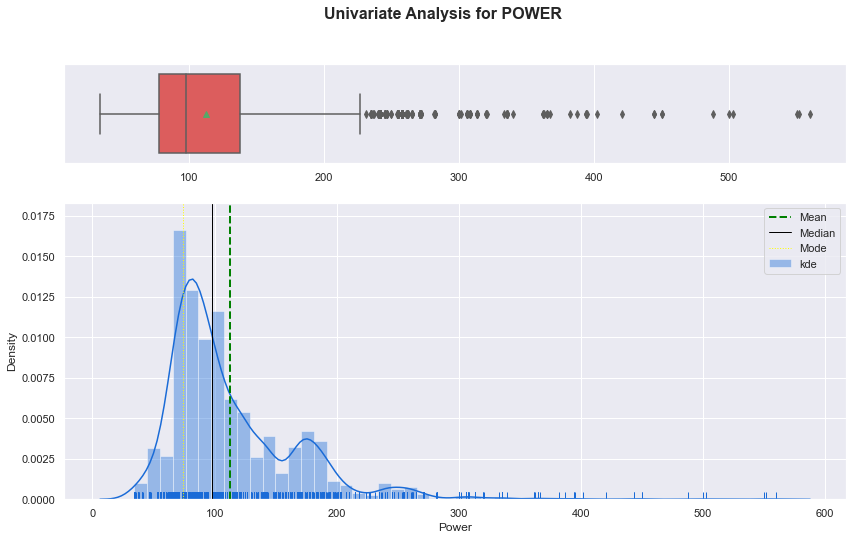

In [36]:
histogram_boxplot(df.Power, figsize=(14, 8))

**Observations**
* Power is very skewed to the right with lots of outliers.
* However most of the vehicles sold have vehicles with low bhp's.

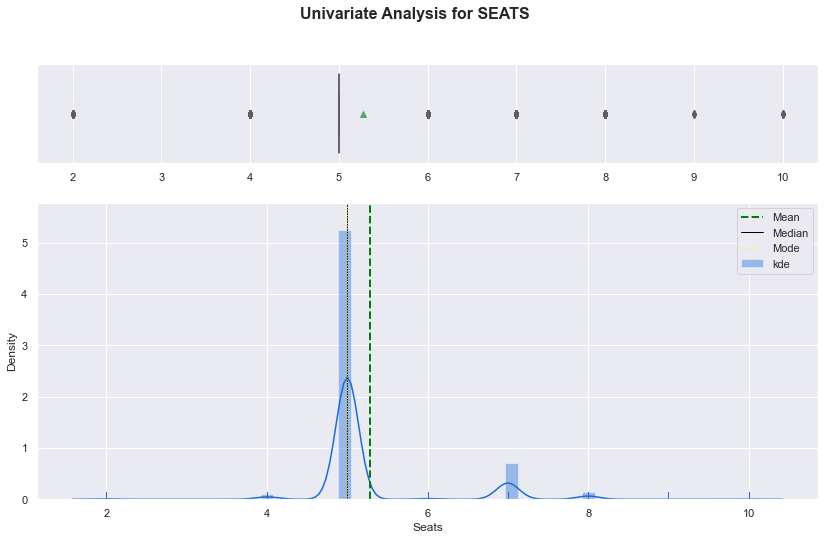

In [37]:
histogram_boxplot(df.Seats, figsize=(14, 8))

**Observations**
* Most vehicles sold have 4-6 seats.

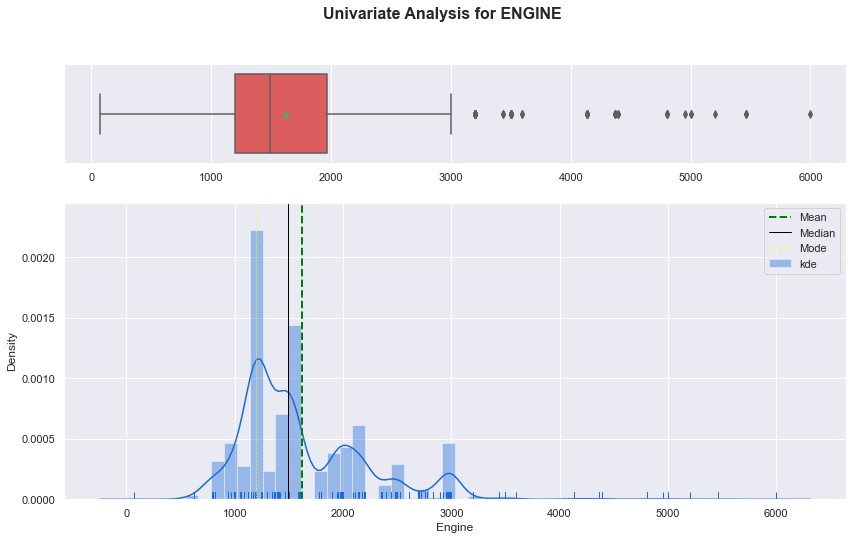

In [38]:
histogram_boxplot(df.Engine, figsize=(14, 8))

**Observations**
* Just like Power(bhps), Engine(CCs) is very skewed to the right with lots of outliers.
* However most of the vehicles sold have vehicles with low CC's.


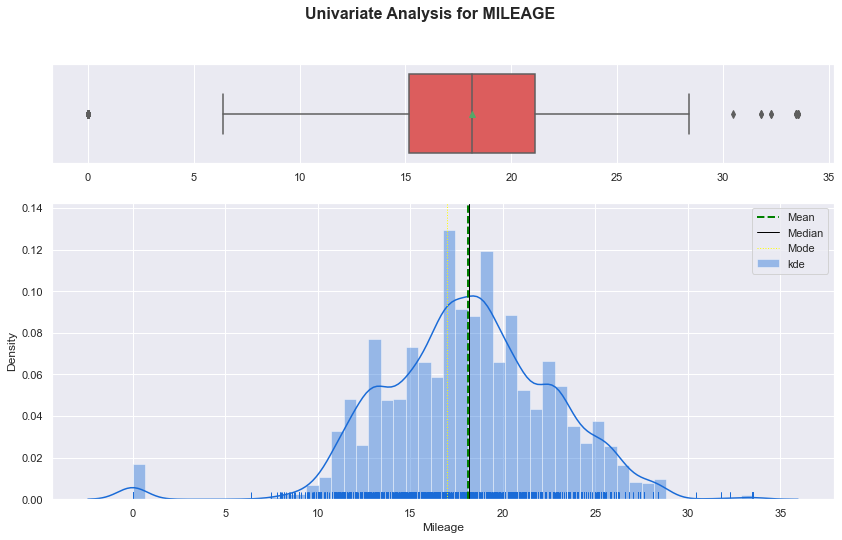

In [39]:
histogram_boxplot(df.Mileage, figsize=(14, 8))

**Observations**
* The majority of car sold have most of their mileage in the 15-22 range.

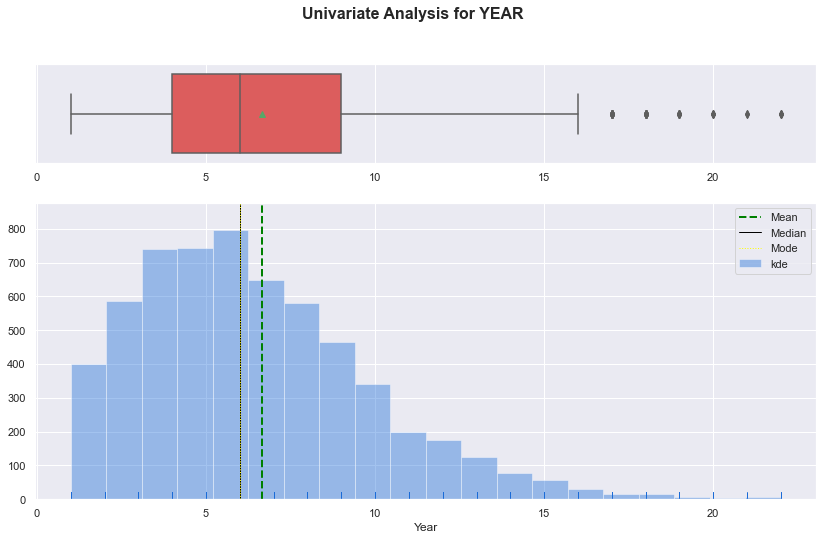

In [40]:
histogram_boxplot(2020-df.Year, figsize=(14, 8),bins=20)

**Observations**
* Plot shows some left skewness, to older vehicles.
* Most of the vehicles sold appear to be in the 3-9 year range.

<H3>Bivariate Analysis</H3>

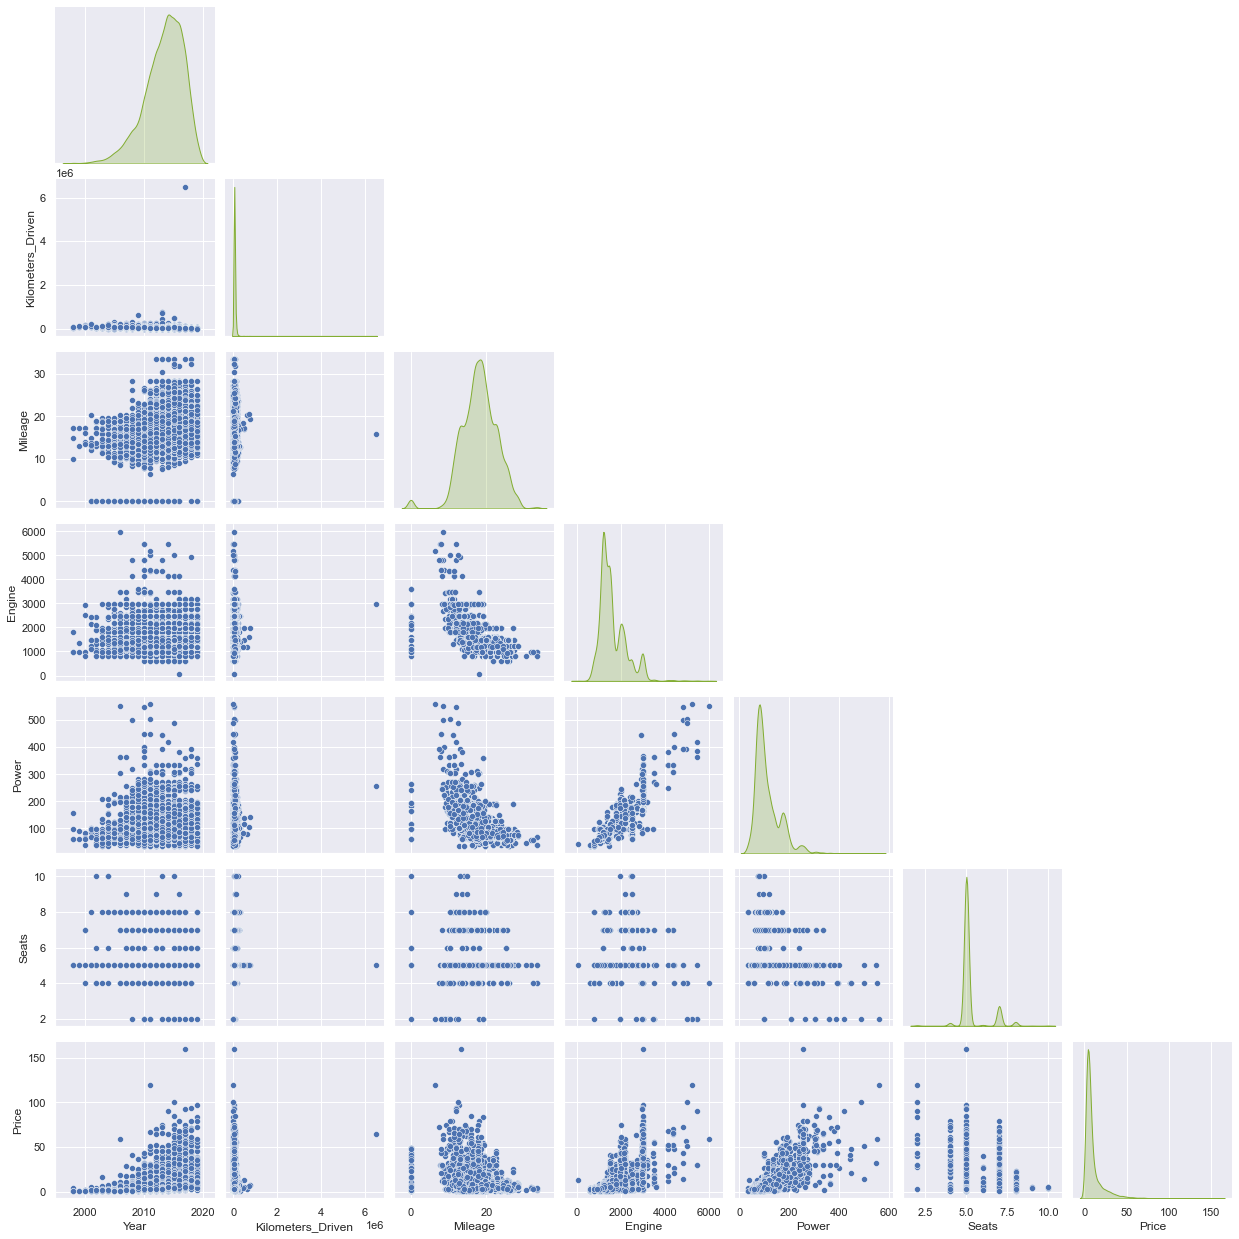

In [41]:
sns.pairplot(data=df,
             vars=get_vars_numerical(df),
             corner=True,
             diag_kind='kde', # vs. auto
             diag_kws= {'color': '#82ad32'}             
             #kind='reg',
             #plot_kws={'line_kws':{'color':'#aec6cf'}},                          
            )

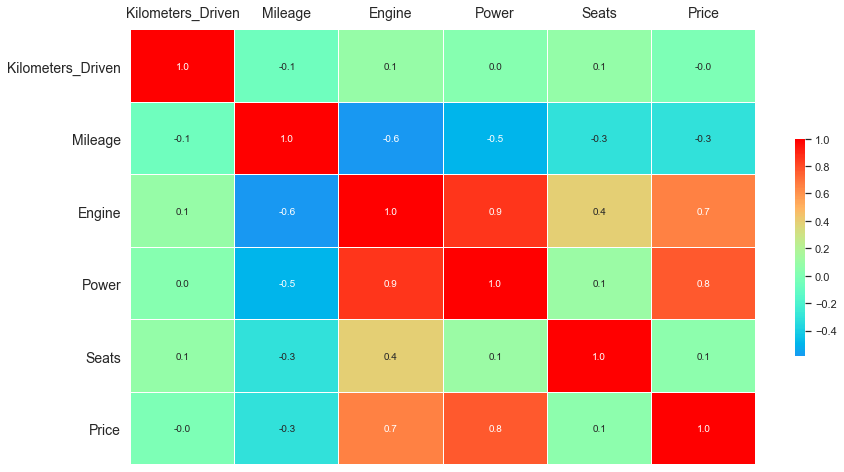

In [42]:
numeric_features = get_vars_numerical(df)
numeric_features.remove("Year")  # dropping year column as it is temporal variable

corr = df[numeric_features].corr()

# plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    data=corr,
    annot=True,
    cmap="rainbow",
    fmt=".1f",
    # fmt="d",
    center=0,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=0.1,
    cbar_kws={"shrink": 0.5},    
)
plt.tick_params(axis='both', which='major', labelsize=14, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

<h4>Observations:</h4>

* Engine and Mileage are inversely correlated.
* Power and Mileage are inversely correlated.
* Number of Seats and Mileage are inversely correlated.
* Price and Mileage are inversely correlated.
* Engine and Price are positively correlated.
* Power and Price are positively correlated. The more power you want, the more you pay.
* Seats and Engine are positively correlated.


<h3>Visualizing correlations with Price:</h3>

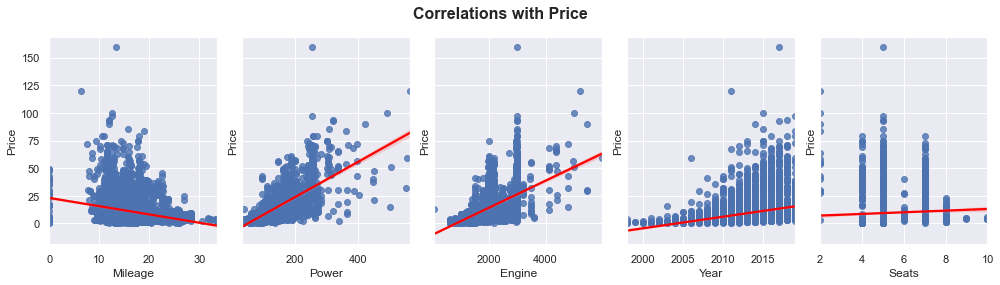

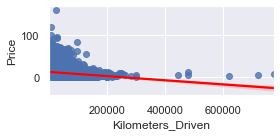

In [43]:
# Check value distributions for Price, Power, Seats, Engine and Mileage to apply the most appropriate central tendency measure.
f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(ncols=5,figsize=(14, 4), sharey=True)

# Plot a simple distribution of the desired columns
sns.regplot(data=df,x="Mileage",y="Price", line_kws={"color": "red"}, ax=ax1)
sns.regplot(data=df,x="Power",y="Price", line_kws={"color": "red"}, ax=ax2)
sns.regplot(data=df,x="Engine",y="Price",line_kws={"color": "red"}, ax=ax3)
sns.regplot(data=df,x="Year",y="Price", line_kws={"color": "red"}, ax=ax4)
sns.regplot(data=df,x="Seats",y="Price", line_kws={"color": "red"}, ax=ax5)

plt.suptitle('Correlations with Price',fontsize=16,fontweight="bold")

plt.tight_layout()
plt.show()

f, (ax1) = plt.subplots(ncols=1,figsize=(4, 2))
sns.regplot(data=df[df.Kilometers_Driven != 6500000],x="Kilometers_Driven",y="Price", line_kws={"color": "red"}, ax=ax1)
plt.tight_layout()
plt.show()

* Car Prices reduce with the increase in mileage.
* Car Prices increase on vehicles with more power, engine CCs.
* Newer Vehicles cost more.

<H3>Categorical Variables Analysis</H3>

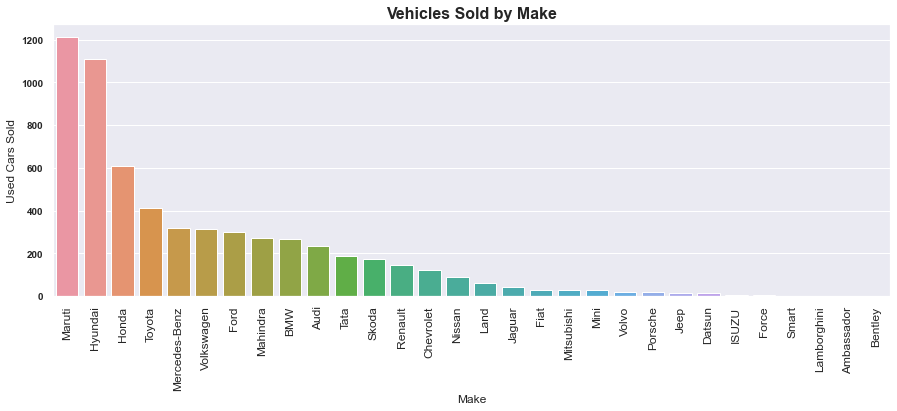

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["Make"],
    order=pd.value_counts(df["Make"]).index,
)
plt1.set(xlabel="Make", ylabel="Used Cars Sold")
plt.title('Vehicles Sold by Make',fontsize=16,fontweight="bold")
plt.yticks(fontsize=10,fontweight="bold")
plt.xticks(rotation=90,fontsize=12,fontweight="normal")
plt.show()

* Maruti, Hyundai, Honda and Toyota are the top selling vehicles.

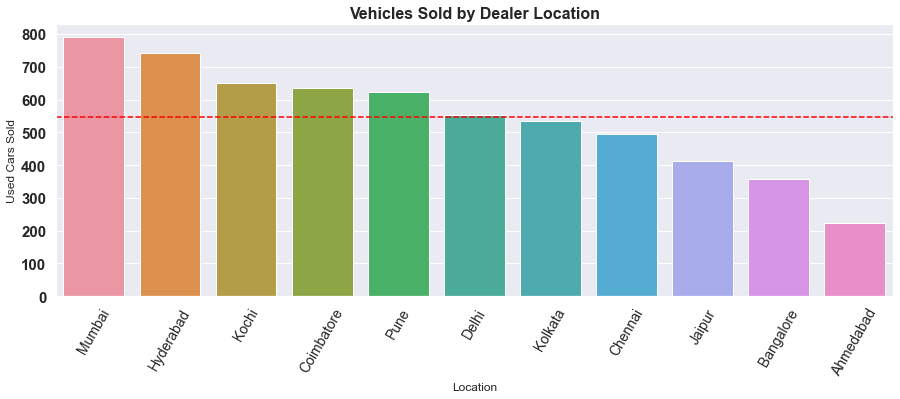

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["Location"],
    order=pd.value_counts(df["Location"]).index,
)
plt1.set(xlabel="Location", ylabel="Used Cars Sold")
plt.title('Vehicles Sold by Dealer Location',fontsize=16,fontweight="bold")
plt.axhline(pd.value_counts(df["Location"]).mean(),color="red",linestyle="--",label="mean")
plt.yticks(fontsize=15,fontweight="bold")
plt.xticks(rotation=60,fontsize=14,fontweight="normal")
plt.show()

* Mumbai, Hyderabad and Kochi are the locations with highest volume of sales.
* Chennai, Jaipur, Bangalore and Ahmedabad are the locations with the lowest volume of sales.

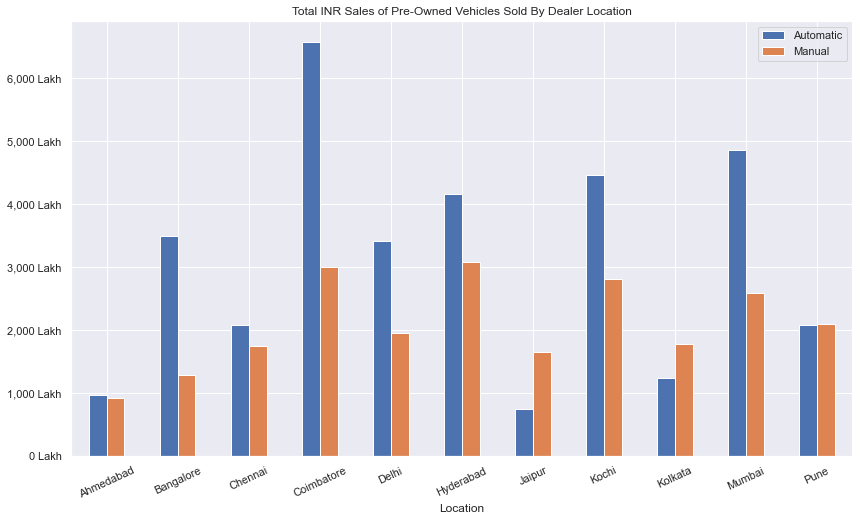

In [46]:
df1=pd.crosstab(index=df.Location,columns=df.Transmission,values=df.Price,aggfunc='sum')
fig1,ax1=plt.subplots(nrows=1,ncols=1,figsize=(14, 8))
df1.plot(kind='bar',ax=ax1,title="Total INR Sales of Pre-Owned Vehicles Sold By Dealer Location")

fmt = '{x:,.0f} Lakh'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
plt.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

* Almedabad, Jaipur, Kolkata, Chennai have the lowest sales revenue.
* Manual transmission has the highest sales revenue in Jaipur and Kolkata.
* Coimbatore, Mumbai and Kochi have the highest revenue and automatic transmissions generating most of the revenue.

<Figure size 1224x648 with 0 Axes>

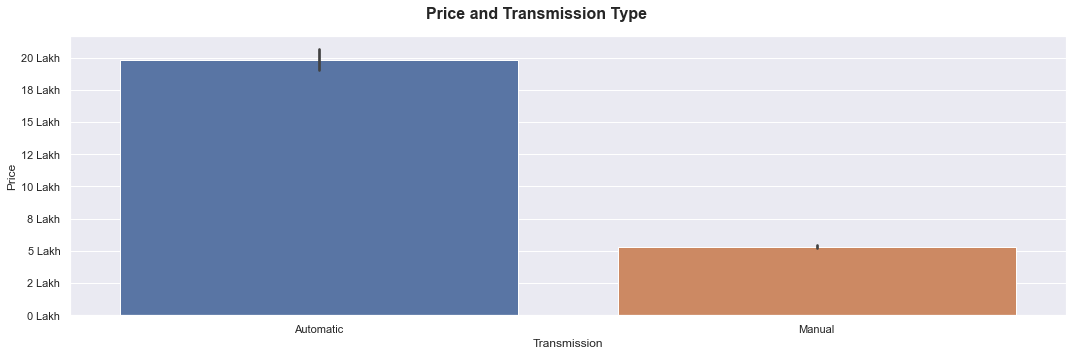

In [47]:
plt.figure(figsize=(17, 9))
f, (ax1) = plt.subplots(ncols=1,figsize=(15, 5))
sns.barplot(data=df,y="Price",x="Transmission", ax=ax1)
plt.suptitle('Price and Transmission Type',fontsize=16,fontweight="bold")
fmt = '{x:,.0f} Lakh'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
plt.tight_layout()
plt.show()

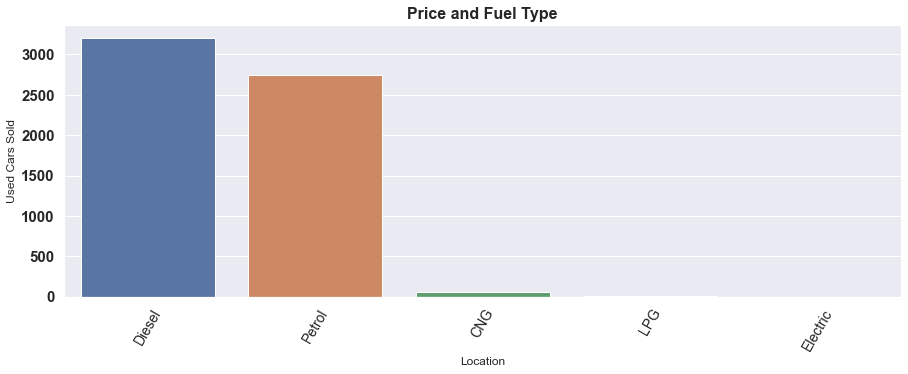

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["Fuel_Type"],
    order=pd.value_counts(df["Fuel_Type"]).index,
)
plt1.set(xlabel="Location", ylabel="Used Cars Sold")
plt.title('Price and Fuel Type',fontsize=16,fontweight="bold")
#plt.axhline(pd.value_counts(df["Fuel_Type"]).mean(),color="red",linestyle="--",label="mean")
plt.yticks(fontsize=15,fontweight="bold")
plt.xticks(rotation=60,fontsize=14,fontweight="normal")
plt.show()

* Automatic Cars cost a whole lot more than Manual transmission cars.

<Figure size 1224x648 with 0 Axes>

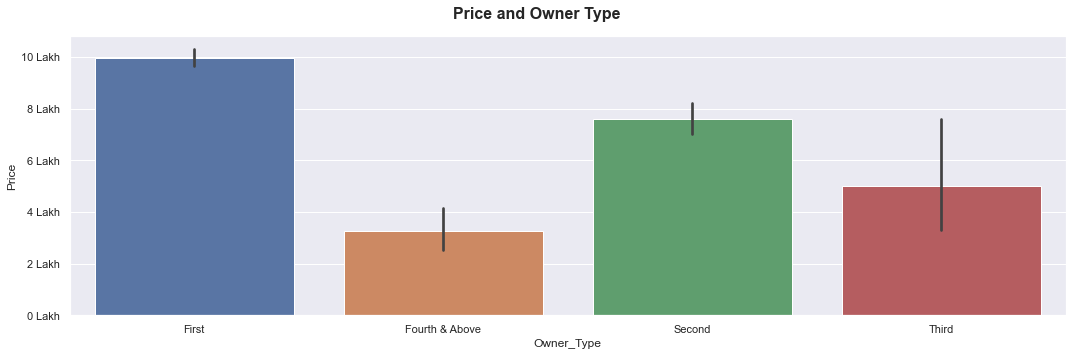

In [49]:
plt.figure(figsize=(17, 9))
f, (ax1) = plt.subplots(ncols=1,figsize=(15, 5))
sns.barplot(data=df,y="Price",x="Owner_Type", ax=ax1)
plt.suptitle('Price and Owner Type',fontsize=16,fontweight="bold")
fmt = '{x:,.0f} Lakh'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
plt.tight_layout()
plt.show()

* Customers prefer First and Second Handed vehicles.
* There is good demand for third, fourth and above pre-owned vehicles.

<Figure size 1224x648 with 0 Axes>

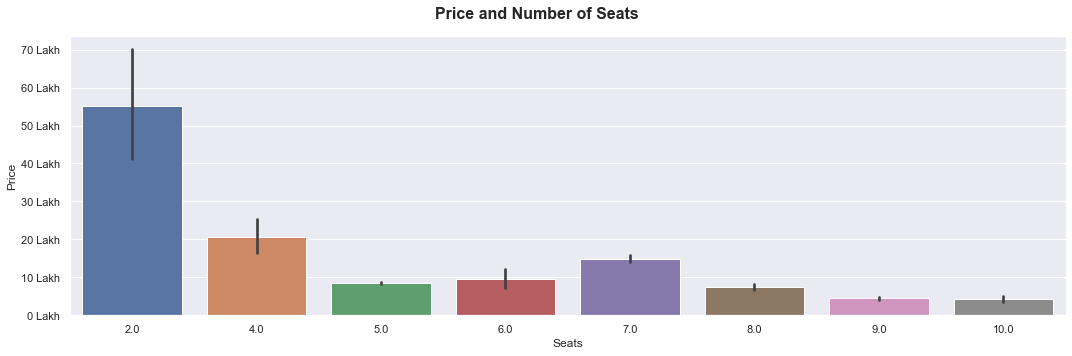

In [50]:
plt.figure(figsize=(17, 9))
f, (ax1) = plt.subplots(ncols=1,figsize=(15, 5))
sns.barplot(data=df,y="Price",x="Seats", ax=ax1)
plt.suptitle('Price and Number of Seats',fontsize=16,fontweight="bold")
fmt = '{x:,.0f} Lakh'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
plt.tight_layout()
plt.show()

<Figure size 1224x648 with 0 Axes>

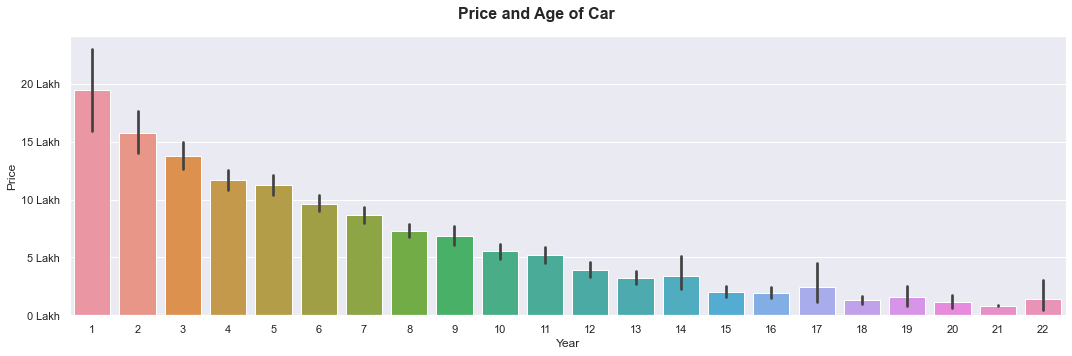

In [51]:
plt.figure(figsize=(17, 9))
f, (ax1) = plt.subplots(ncols=1,figsize=(15, 5))
sns.barplot(y=df["Price"],x=2020-df["Year"], ax=ax1)
plt.suptitle('Price and Age of Car',fontsize=16,fontweight="bold")
fmt = '{x:,.0f} Lakh'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
plt.tight_layout()
plt.show()

<h3>Resolving Outliers</h3>

In [52]:
skewed_features(df)

Kilometers_Driven    58.710026
Price                 3.334401
Power                 1.953635
Seats                 1.908501
Engine                1.428585
Mileage              -0.431710
Year                 -0.845591
dtype: float64

In [53]:
"""
Option One:
Treat highly skewed features, using the IQR method. Uncomment this section if need to revisit this option.
"""
# numerical_col = ["Price","Engine","Power","Kilometers_Driven"] ## Not including Year
# df = treat_outliers_all(df, numerical_col)

'\nOption One:\nTreat highly skewed features, using the IQR method. Uncomment this section if need to revisit this option.\n'

In [54]:
"""
Second Option ( Chosen ): 

Tested both alternatives and this option showed a better R^2 score compared with option one. 
Option one 0.906 vs 0.933 t

Although price shows to be skewed across the rows, the values seem
consistent with the price of the vehicle for the most part.
Very expensive luxury cars tend to be expensive skewing the data.

Kilometers_Driven has one outlier (6500000) that is the major issue. I am replacing this value with the median.
"""

df.loc[df.Kilometers_Driven == 6500000, "Kilometers_Driven"] = df[df.Kilometers_Driven != 6500000].Kilometers_Driven.median()


In [55]:
skewed_features(df)

Kilometers_Driven    4.204099
Price                3.334401
Power                1.953635
Seats                1.908501
Engine               1.428585
Mileage             -0.431710
Year                -0.845591
dtype: float64

* Note a significant drop in Kilometers_Driven skewness after this small fix, while preserving the rest of the data.
* Opting to preserve the rest of the variables intact per R^2 score result comparison against the alternative of treating outliers with the IQR method.

<h3>Binning Seats</h3>

In [56]:
# number of seats breakdown
df["Seats"].value_counts()

5.0     5056
7.0      675
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
Name: Seats, dtype: int64

In [57]:
# For Seats create the following category bins:
df["Seats_bin"] = pd.cut(
    df["Seats"], [-np.inf, 4, 6, np.inf], labels=["4 and Under", "5-6", "Over 6"]
)

df["Seats_bin"] = (
    df["Seats_bin"].astype("object").fillna("Undetermined").astype("category")
)
df["Seats_bin"] = df["Seats_bin"].astype("category")
# Show seats counts after binning
df["Seats_bin"].value_counts(dropna=False)

df.drop(["Seats"], axis=1, inplace=True)

In [58]:
df.sample(n=2)

,Make,Make_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Price,Seats_bin
2796,BMW,BMW 3,Pune,2011,43706,Petrol,Automatic,First,10.9,2497.0,215.0,9.00,5-6
4851,Chevrolet,Chevrolet Spark,Chennai,2011,29000,Petrol,Manual,Second,18.0,995.0,62.0,1.75,5-6


<h3>Log Transformation</h3>

Some variables are very skewed and will likely shoe better results on the log scale.

Transforming Kilometers_Driven, Price, Power, Engine:

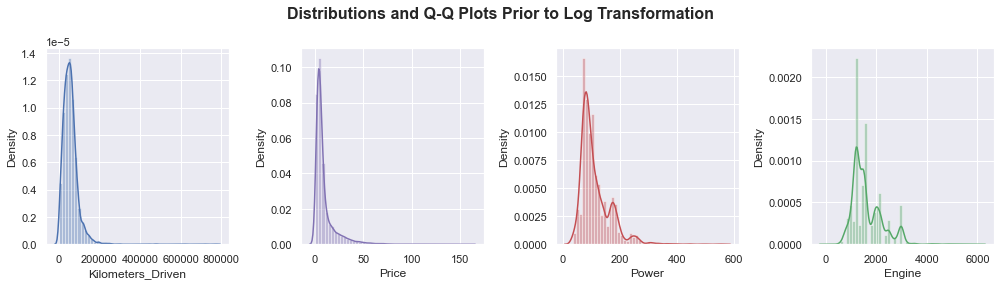

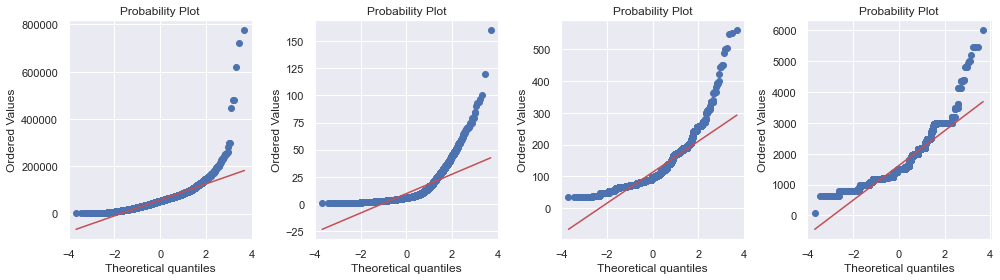

In [59]:
cars4u_show_dist_qq(df,'Distributions and Q-Q Plots Prior to Log Transformation')

In [60]:
# Applying Log transformation

df["Kilometers_Driven"] = np.log(df["Kilometers_Driven"])
df["Price"] = np.log(df["Price"])
df["Power"] = np.log(df["Power"])
df["Engine"] = np.log(df["Engine"])

# Show results post log transformation

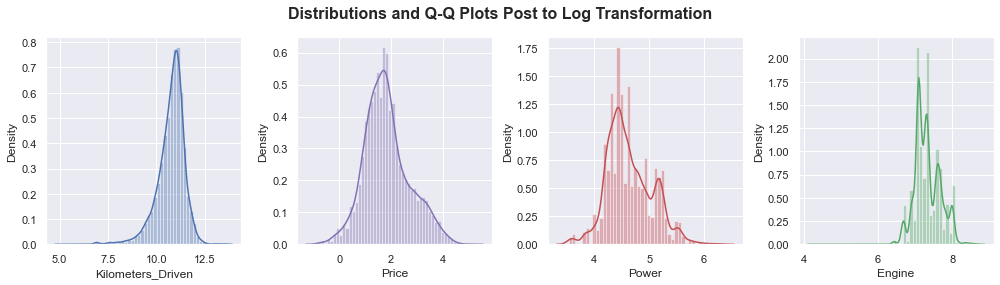

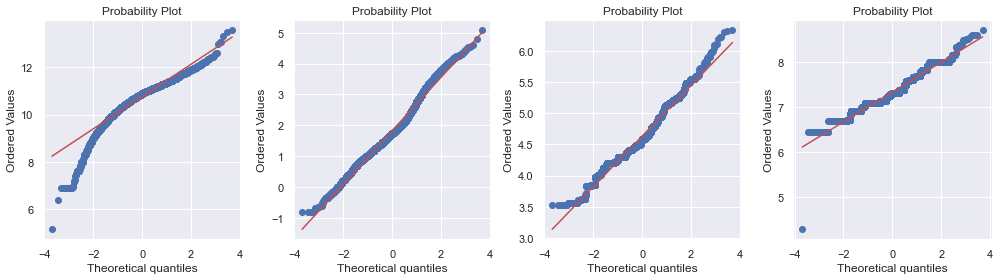

In [61]:
cars4u_show_dist_qq(df,'Distributions and Q-Q Plots Post to Log Transformation')

* Now these look closer to a more normal distribution !
* The Q-Q plot follows the red 45 degree line, which indicates that the data values follow a normal distribution.

<h3>Data Prepping for Modeling</h3>

In [62]:
df.drop(["Make_Model"], axis=1, inplace=True)
# Seats_bin affected the model in a very negative way. 
# Will not include it on the train/test set. 
df.drop(["Seats_bin"], axis=1, inplace=True)

<h4>One-Hot Encoding</h4>

In [63]:
# Create dummy variables for the following:
df_t = pd.get_dummies(
    df,
    columns=[        
        "Owner_Type",
        "Fuel_Type",
        "Transmission",
        "Location",
        "Make",
        #"Seats_bin",        
    ],
    drop_first=True,
)

df_t.sample(n=5)

,Year,Kilometers_Driven,Mileage,Engine,Power,Price,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Make_Audi,Make_BMW,Make_Bentley,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Force,Make_Ford,Make_Honda,Make_Hyundai,Make_ISUZU,Make_Jaguar,Make_Jeep,Make_Lamborghini,Make_Land,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo
2404,2016,11.198215,25.17,6.683361,3.975936,1.163151,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2676,2017,10.608044,19.67,7.366445,4.837868,2.586259,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3329,2016,11.234533,24.00,7.021084,4.248495,1.740466,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1021,2013,11.002100,22.07,7.089243,4.302713,1.558145,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
675,2007,10.572265,14.84,7.669962,5.135798,2.224624,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       6019 non-null   int64  
 1   Kilometers_Driven          6019 non-null   float64
 2   Mileage                    6019 non-null   float64
 3   Engine                     6019 non-null   float64
 4   Power                      6019 non-null   float64
 5   Price                      6019 non-null   float64
 6   Owner_Type_Fourth & Above  6019 non-null   uint8  
 7   Owner_Type_Second          6019 non-null   uint8  
 8   Owner_Type_Third           6019 non-null   uint8  
 9   Fuel_Type_Diesel           6019 non-null   uint8  
 10  Fuel_Type_Electric         6019 non-null   uint8  
 11  Fuel_Type_LPG              6019 non-null   uint8  
 12  Fuel_Type_Petrol           6019 non-null   uint8  
 13  Transmission_Manual        6019 non-null   uint8

* Observed all the variables are now numerical, ready for modeling.

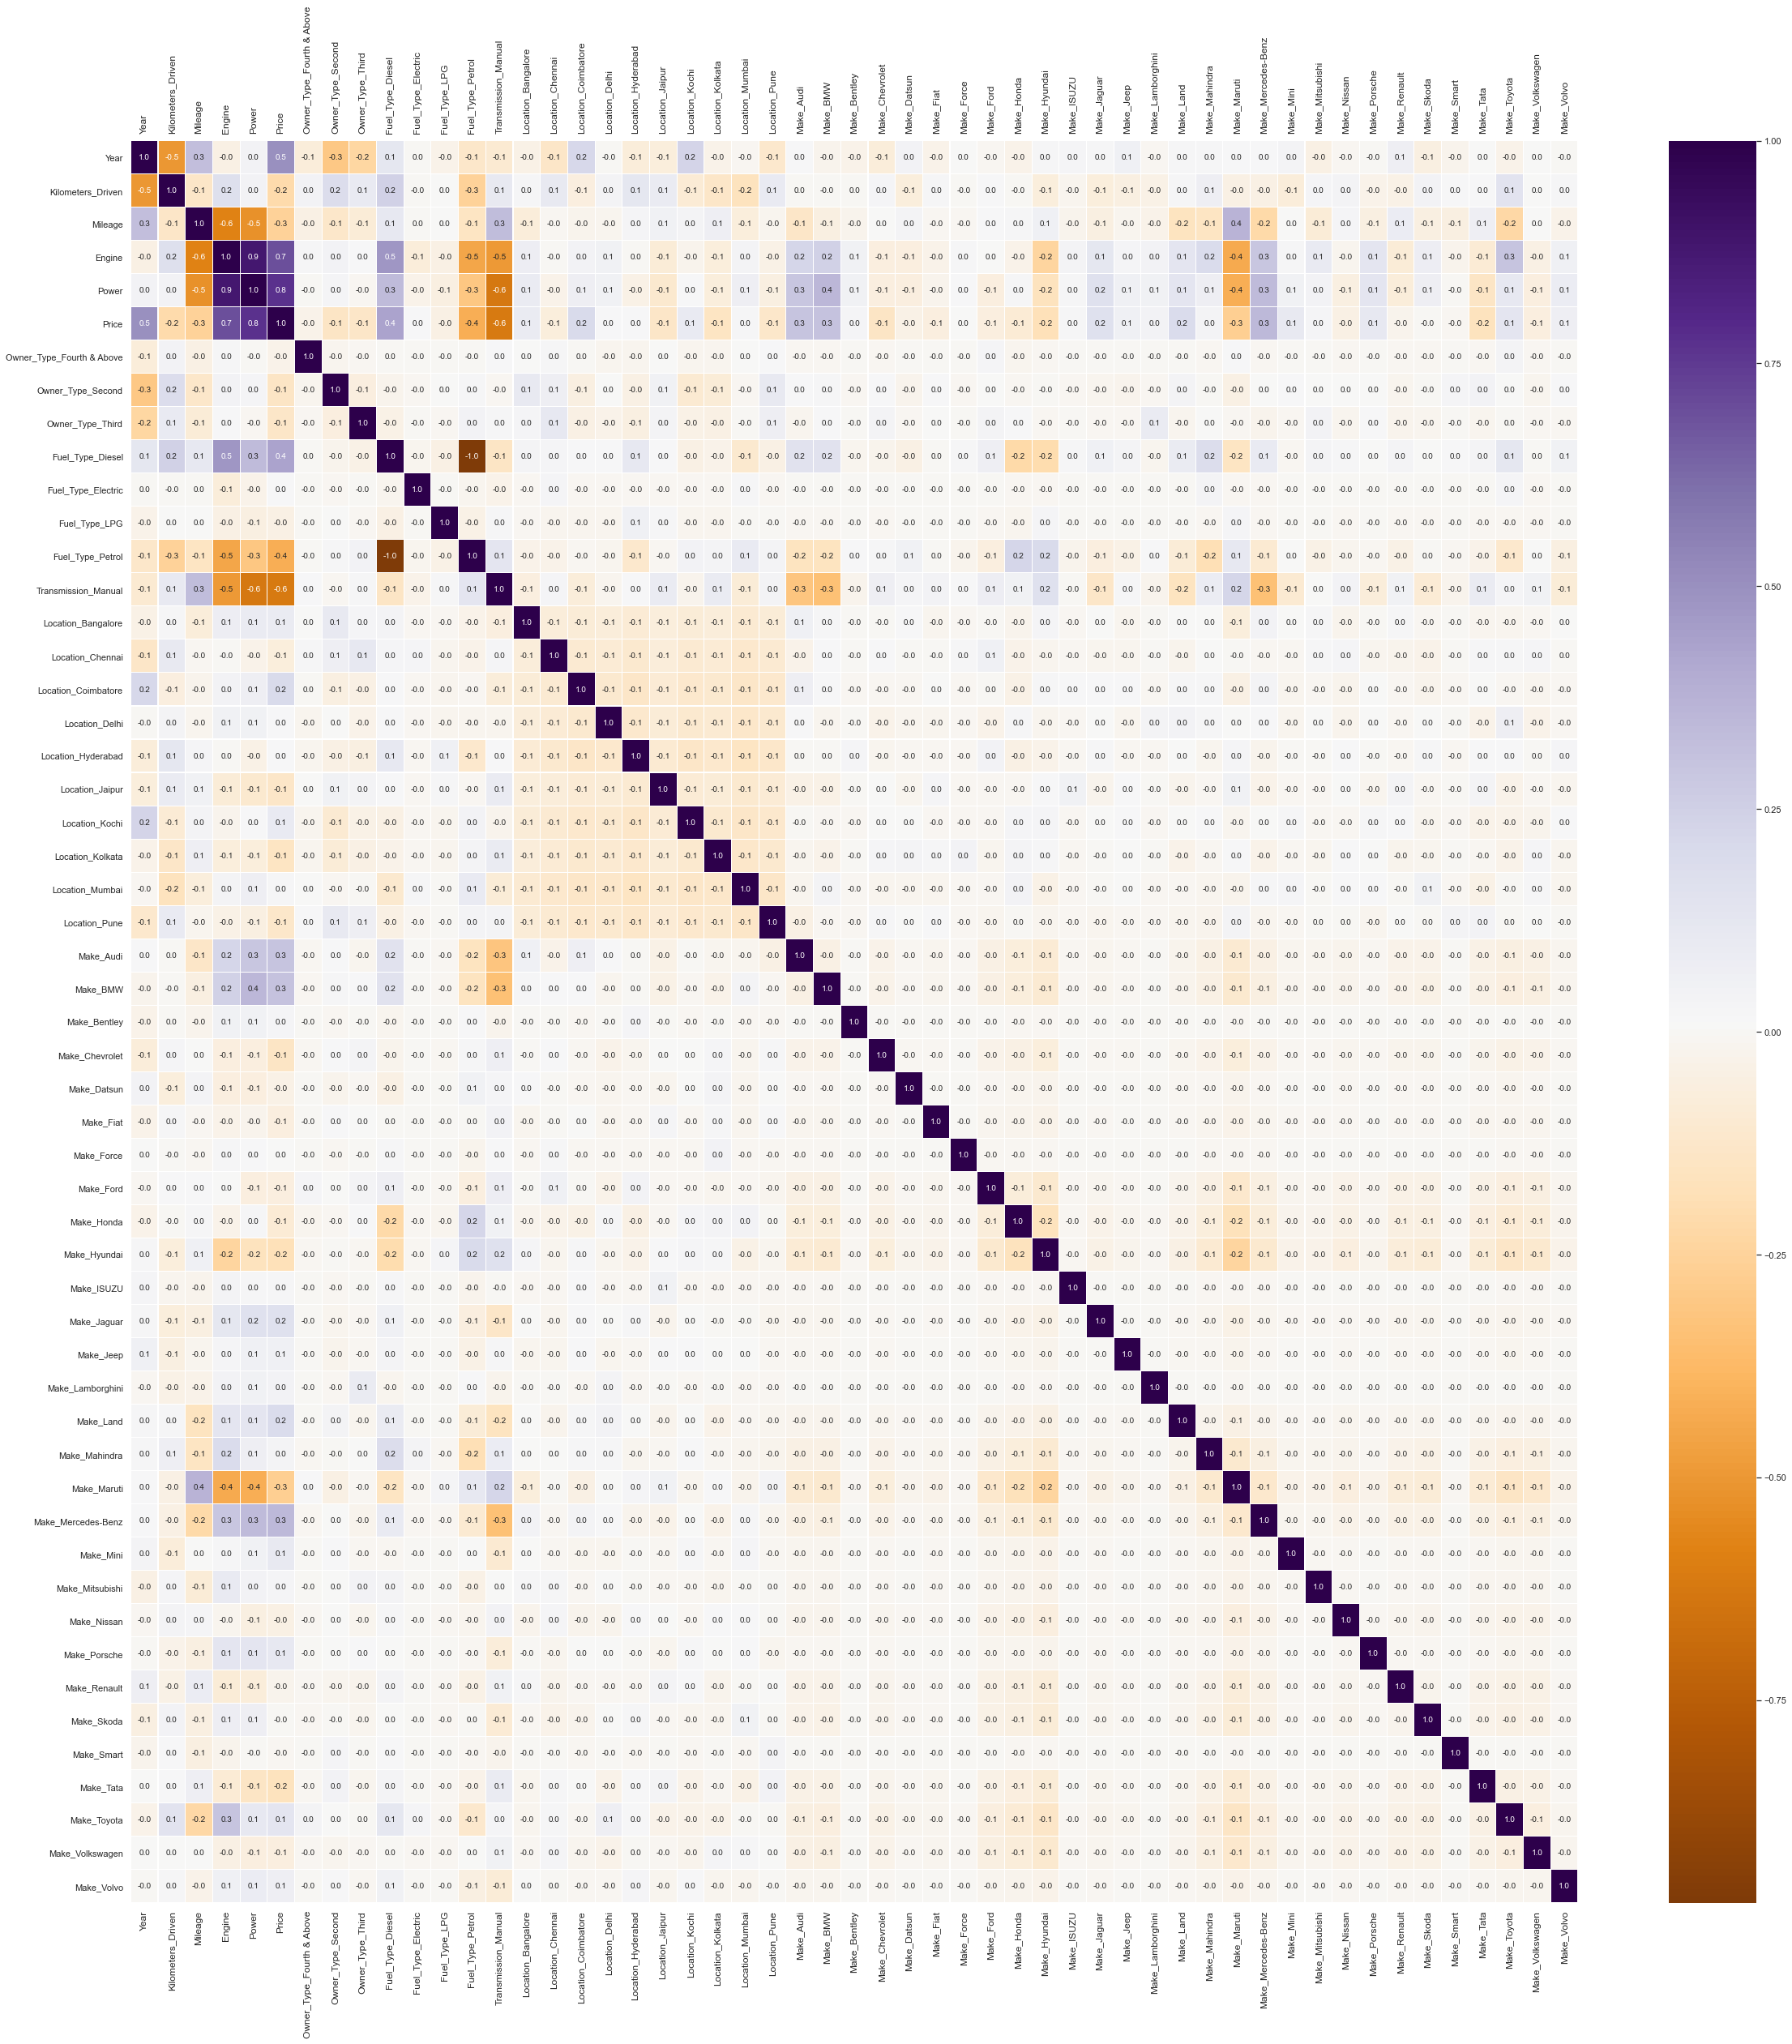

In [65]:
#Correlation heatmap
f, ax = plt.subplots(figsize=[40,40])
sns.heatmap(df_t.corr(), ax=ax,  annot=True, linewidths=0.1, fmt= '.1f',cmap="PuOr")
ax.tick_params(axis='x',
               which='major',
               labelsize=12,
               labelbottom = True,
               bottom=False,
               top = False,
               labelrotation = 90,
               labeltop=True)  #top=False means no ticks
f.show();

**Looking for high correlations:**

In [66]:
corr = df_t.corr().abs()
high_corr_features = np.where(corr>0.8)
high_corr_features = [(corr.columns[x],corr.columns[y])
                          for x,y in zip(*high_corr_features) if x!=y and x<y]
high_corr_features

[('Engine', 'Power'), ('Fuel_Type_Diesel', 'Fuel_Type_Petrol')]

* Engine and Power are highly correlated. (corr > 0.8)
* The same with fuel types Diesel and Petrol.
* High correlation variables causes multicollinearity which affect the model.
* These variables will be evaluated again later in the analysis of assumptions of model building and VIF checks.

<h3>Prepping data for linear model, x and y values</h3>

In [67]:
# defining X and y variables
X = df_t.drop(["Price"], axis=1)  # Dropping dependent variable Price as it will be moved to the y axis.
y = df_t[["Price"]]

In [68]:
# Looking at X and y
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       6019 non-null   int64  
 1   Kilometers_Driven          6019 non-null   float64
 2   Mileage                    6019 non-null   float64
 3   Engine                     6019 non-null   float64
 4   Power                      6019 non-null   float64
 5   Owner_Type_Fourth & Above  6019 non-null   uint8  
 6   Owner_Type_Second          6019 non-null   uint8  
 7   Owner_Type_Third           6019 non-null   uint8  
 8   Fuel_Type_Diesel           6019 non-null   uint8  
 9   Fuel_Type_Electric         6019 non-null   uint8  
 10  Fuel_Type_LPG              6019 non-null   uint8  
 11  Fuel_Type_Petrol           6019 non-null   uint8  
 12  Transmission_Manual        6019 non-null   uint8  
 13  Location_Bangalore         6019 non-null   uint8

<h3>Create Test and Train Data</h3>

In [69]:
# split the data into test (30%) and Train(70%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [70]:
#free up mem as these df as no longer being used
#import gc
#del [[cars4u_data,df,df_with_dummies]]
#gc.collect() #collect garbage

In [71]:
X_train.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Make_Audi,Make_BMW,Make_Bentley,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Force,Make_Ford,Make_Honda,Make_Hyundai,Make_ISUZU,Make_Jaguar,Make_Jeep,Make_Lamborghini,Make_Land,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo
4201,2011,11.251561,22.07,7.089243,4.302713,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4383,2016,9.900834,20.36,7.087574,4.368181,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1779,2014,11.169914,15.10,7.686621,4.941642,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4020,2013,11.654382,25.20,7.129298,4.304065,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3248,2011,10.981080,16.47,7.088409,4.302713,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


<h3>Choosing Linear Model, Fit Train data and Evaluate results<h3>

In [72]:
# fitting the model on the train data (70% of the whole data)
from sklearn.linear_model import LinearRegression

linearregression = LinearRegression()
linearregression.fit(X_train, y_train)

LinearRegression()

In [73]:
# Checking the coefficients and intercept of the model
print('Linear regression axis intercept:',linearregression.intercept_);
print('\nLinear regression equation coefficients:\n\n',linearregression.coef_ );

Linear regression axis intercept: [-242.14402619]

Linear regression equation coefficients:

 [[ 1.18615857e-01 -6.68951542e-02 -9.43591859e-03  4.38681971e-01
   6.52597776e-01 -9.85090546e-03 -6.09198699e-02 -1.64874154e-01
   1.54681187e-01  2.51896915e+00 -1.53303709e-02 -4.81098336e-02
  -9.87294338e-02  1.32195580e-01  9.82294552e-03  9.14866940e-02
  -1.02278762e-01  9.61854616e-02 -6.65032254e-02 -5.31638973e-02
  -2.51679311e-01 -6.70724809e-02 -5.82236197e-02  3.69456803e-01
   3.36705020e-01 -2.05391260e-15 -5.44045208e-01 -5.65277453e-01
  -4.76194159e-01 -1.93674344e-01 -3.12743492e-01 -2.58931137e-01
  -2.56128450e-01 -5.12086036e-01  4.60242084e-01 -9.30430487e-02
   1.47451271e+00  7.21498103e-01 -3.53896759e-01 -1.90807327e-01
   3.50364013e-01  7.02947721e-01  8.37971723e-03 -2.82264300e-01
   8.91376870e-01 -2.65323599e-01 -2.36558224e-01  1.11022302e-16
  -6.87666937e-01 -1.97877344e-02 -2.75732399e-01  2.08677566e-01]]


**Checking the performance of the model using metrics MAE, MAPE, RMSE and R^2**

In [74]:
# Checking model performance on train set (seen 70% data)
print("Train Performance Results:\n")
model_perf(linearregression, X_train, y_train)

Train Performance Results:



,MAE,MAPE,RMSE,R^2,AR^2
0,0.166593,inf,0.219202,0.93615,0.9305


In [75]:
# Checking model performance on test set (unseen 30% data)
print("Test Performance Results:\n")
model_perf(linearregression, X_test, y_test)

Test Performance Results:



,MAE,MAPE,RMSE,R^2,AR^2
0,0.177473,inf,0.251616,0.919875,0.9305


**Observations**

* The training and testing both scores results are ~92%.
* This regression model results in an excellent fit!
* R-squared is 0.936 on the test set. This means the model explains ~92% of total variation in the test dataset.
* The adjusted R-squared is 0.93 on both the test set and train set, consistent with and a little better result than R^2.
* The model is very satisfactory given the results.
* MAE indicates that the current model is able to predict price within a mean error of ~0.18 Lakh on the test data.


<h3>Chosen model olsres11 summary</h3>

In [76]:
# Build linear regression model using statsmodel
# unlike sklearn, statsmodels does not add a constant to the data on its own
# we have to add the constant manually
X = sm.add_constant(X)
X_train1, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

olsmod0 = sm.OLS(y_train, X_train1)
olsres0 = olsmod0.fit()
print(olsres0.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1246.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:09   Log-Likelihood:                 416.34
No. Observations:                4213   AIC:                            -732.7
Df Residuals:                    4163   BIC:                            -415.4
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [77]:
# Noticed some P_values > 0.05.
# The columns could possibly be reduced which would result in lesser coeficients to include the final equation.
# To try to achieve a better R2 we typically drop x coeficients with P_values < 0.05
# one by one and refit and reevalute is there is a better result in R^2.

<h3>Checking Linear Regression Assumptions</h3>

**Let's check now the folowing Linear Regression assumptions:**

1. No Multicollinearity

2. Mean of residuals should be 0

3. No Heteroscedasticity

4. Linearity of variables

5. Normality of error terms

**Test for Multicollinearity -  Using Variance Inflation Factor (VIF)**

In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_series1 = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns
)
print("VIF Scores: \n\n{}\n".format(vif_series1))

VIF Scores: 

const                        853227.489983
Year                              2.196270
Kilometers_Driven                 1.780818
Mileage                           2.962877
Engine                           10.258379
Power                             8.486284
Owner_Type_Fourth & Above         1.016208
Owner_Type_Second                 1.178148
Owner_Type_Third                  1.132223
Fuel_Type_Diesel                 28.882001
Fuel_Type_Electric                1.098181
Fuel_Type_LPG                     1.194736
Fuel_Type_Petrol                 29.466320
Transmission_Manual               2.281042
Location_Bangalore                2.485650
Location_Chennai                  3.006125
Location_Coimbatore               3.540052
Location_Delhi                    3.181306
Location_Hyderabad                3.830331
Location_Jaipur                   2.692039
Location_Kochi                    3.589981
Location_Kolkata                  3.151539
Location_Mumbai                   4.0265

In [79]:
pd.set_option('display.max_rows', vif_series1.shape[0]+1)
print("VIF Scores: \n\n{}\n".format(vif_series1[vif_series1 >10])) 

VIF Scores: 

const                 853227.489983
Engine                    10.258379
Fuel_Type_Diesel          28.882001
Fuel_Type_Petrol          29.466320
Make_Audi                232.917780
Make_BMW                 262.314031
Make_Chevrolet           121.615374
Make_Datsun               14.216135
Make_Fiat                 29.386004
Make_Ford                290.669219
Make_Honda               558.564853
Make_Hyundai             921.619446
Make_Jaguar               41.723248
Make_Jeep                 16.326509
Make_Land                 61.663053
Make_Mahindra            264.952540
Make_Maruti              986.076484
Make_Mercedes-Benz       308.864709
Make_Mini                 27.468545
Make_Mitsubishi           28.273811
Make_Nissan               92.170663
Make_Porsche              19.395523
Make_Renault             145.156563
Make_Skoda               172.278895
Make_Tata                184.298860
Make_Toyota              390.294441
Make_Volkswagen          304.833171
Make_Volvo    

* Observed some high VIF values, indicating that there are multicollinearity. 
* Let's drop the highest "Make" variable, which is **Make_Maruti**.
* It was observed earlier that the df_t.corr() returned the following strong correlations:
    * [('Engine', 'Power'), ('Fuel_Type_Diesel', 'Fuel_Type_Petrol')]    
* Let's also drop **Engine** and **Fuel_Type_Diesel**
* Then let's recheck  VIF values in a new X_train2.

### Removing Multicollinearity

To remove multicollinearity

1. Drop every column one by one that has VIF score greater than 5.
2. Look at the adjusted R-squared of all these models.
3. Drop the variable that makes least change in adjusted R-squared.
4. Check the VIF scores again.
5. Continue till you get all VIF scores under 5.

In [80]:
X_train2 = X_train1.drop(["Engine","Fuel_Type_Diesel","Make_Maruti"], axis=1)
vif_series2 = pd.Series(
    [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])],
    index=X_train2.columns,
)
print("VIF Scores: \n\n{}\n".format(vif_series2))

VIF Scores: 

const                        851513.117739
Year                              2.179103
Kilometers_Driven                 1.783685
Mileage                           2.697683
Power                             3.816805
Owner_Type_Fourth & Above         1.013511
Owner_Type_Second                 1.173660
Owner_Type_Third                  1.138902
Fuel_Type_Electric                1.017173
Fuel_Type_LPG                     1.023611
Fuel_Type_Petrol                  2.049066
Transmission_Manual               2.257515
Location_Bangalore                2.597255
Location_Chennai                  3.021097
Location_Coimbatore               3.605884
Location_Delhi                    3.268969
Location_Hyderabad                3.901355
Location_Jaipur                   2.698020
Location_Kochi                    3.668307
Location_Kolkata                  3.222760
Location_Mumbai                   4.080722
Location_Pune                     3.526315
Make_Audi                         1.8891

* VIF scores improved substantially! 

**Moving on to removing non-significant ( P > 0.05 ) variables in the model.**

In [81]:
#Creating a new least square model, using the previous X_train1 data.
olsmod1 = sm.OLS(y_train, X_train2)
olsres1 = olsmod1.fit()
print(olsres1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1237.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:10   Log-Likelihood:                 319.40
No. Observations:                4213   AIC:                            -542.8
Df Residuals:                    4165   BIC:                            -238.2
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

* Removing Owner_Type_Fourth & Above P_Value = 0.937>0.05, due to low significance to the model.

In [82]:
#Creating a new least square model, using the previous X_train2 data.
X_train3 = X_train2.drop(["Owner_Type_Fourth & Above"],axis=1)

olsmod2 = sm.OLS(y_train, X_train3)
olsres2 = olsmod2.fit()
print(olsres2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1264.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:10   Log-Likelihood:                 319.37
No. Observations:                4213   AIC:                            -544.7
Df Residuals:                    4166   BIC:                            -246.5
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.3034    

* Noticed no improvement on R^2, let's train a new X_train4 model, without "Make_Skoda". P_Value=0.834 > 0.05

In [83]:
#Creating a new least square model
X_train4 = X_train3.drop(["Make_Skoda"],axis=1)

olsmod3 = sm.OLS(y_train, X_train4)
olsres3 = olsmod3.fit()
print(olsres3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1292.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:10   Log-Likelihood:                 319.23
No. Observations:                4213   AIC:                            -546.5
Df Residuals:                    4167   BIC:                            -254.5
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.3714    

In [84]:
#Creating a new least square model
X_train5 = X_train4.drop(["Make_Force"],axis=1)

olsmod5 = sm.OLS(y_train, X_train5)
olsres5 = olsmod5.fit()
print(olsres5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1322.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:10   Log-Likelihood:                 319.15
No. Observations:                4213   AIC:                            -548.3
Df Residuals:                    4168   BIC:                            -262.7
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.3838    

In [85]:
#Creating a new least square model
X_train6 = X_train5.drop(["Location_Jaipur"],axis=1)

olsmod5 = sm.OLS(y_train, X_train6)
olsres5 = olsmod5.fit()
print(olsres5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1351.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:11   Log-Likelihood:                 315.79
No. Observations:                4213   AIC:                            -543.6
Df Residuals:                    4169   BIC:                            -264.4
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.3778    

In [86]:
#Creating a new least square model
X_train7 = X_train6.drop(["Location_Kochi"],axis=1)

olsmod6 = sm.OLS(y_train, X_train7)
olsres6 = olsmod6.fit()
print(olsres6.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1383.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:11   Log-Likelihood:                 315.46
No. Observations:                4213   AIC:                            -544.9
Df Residuals:                    4170   BIC:                            -272.1
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -237.9938    

In [87]:
#Creating a new least square model
X_train8 = X_train7.drop(["Location_Pune"],axis=1)

olsmod7 = sm.OLS(y_train, X_train8)
olsres7 = olsmod7.fit()
print(olsres7.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1417.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:11   Log-Likelihood:                 315.30
No. Observations:                4213   AIC:                            -546.6
Df Residuals:                    4171   BIC:                            -280.1
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.1780    

In [88]:
#Creating a new least square model
X_train9 = X_train8.drop(["Location_Mumbai"],axis=1)

olsmod8 = sm.OLS(y_train, X_train9)
olsres8 = olsmod8.fit()
print(olsres8.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1452.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:11   Log-Likelihood:                 314.39
No. Observations:                4213   AIC:                            -546.8
Df Residuals:                    4172   BIC:                            -286.6
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.7235    

In [89]:
#Creating a new least square model
X_train10 = X_train9.drop(["Make_ISUZU"],axis=1)

olsmod9 = sm.OLS(y_train, X_train10)
olsres9 = olsmod9.fit()
print(olsres9.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1489.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:11   Log-Likelihood:                 313.12
No. Observations:                4213   AIC:                            -546.2
Df Residuals:                    4173   BIC:                            -292.4
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.5884    

In [90]:
#Creating a new least square model
X_train11 = X_train10.drop(["Make_Jeep"],axis=1)

olsmod10 = sm.OLS(y_train, X_train11)
olsres10 = olsmod10.fit()
print(olsres10.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1528.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:11   Log-Likelihood:                 312.59
No. Observations:                4213   AIC:                            -547.2
Df Residuals:                    4174   BIC:                            -299.7
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.7382    

In [91]:
#Creating a new least square model
X_train12 = X_train11.drop(["Make_Nissan"],axis=1)

olsmod11 = sm.OLS(y_train, X_train12)
olsres11 = olsmod11.fit()
print(olsres11.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1568.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:11   Log-Likelihood:                 311.17
No. Observations:                4213   AIC:                            -546.3
Df Residuals:                    4175   BIC:                            -305.2
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.6147    

<h4>All the features in X_train12 have p-value < 0.05.</h4>

<h4>The features in X_train12 will be used as the chosen features.</h4>

<h4>olsres11 is the chosen model.</h4>

<h2>Checking the assumptions on the model chosen (olsres11) </h2>

<h3>Mean of Residuals</h3>

In [92]:
residual = olsres11.resid
np.mean(residual)

3.6713676116435397e-13

* Mean of residuals should be zero.
* Mean of residuals in the model is very close to zero.

<h3>Test for Linearity</h3>

In [93]:
# Residuals vs Fitted. Used to check the linear relationship assumptions
residual = olsres2.resid
fitted = olsres2.fittedvalues  # predicted values

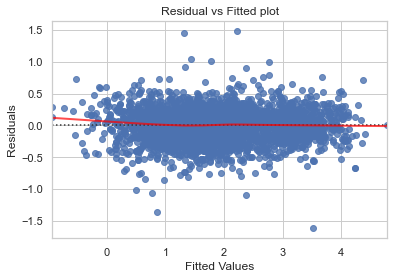

In [94]:
sns.set_style("whitegrid")
sns.residplot(fitted, residual, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.7})
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual vs Fitted plot")
plt.show()

**Observation**

* Not a perfect horizontal line, but a good indication of a linear relationship for the most part.

<H3>Test for Normality</H3>

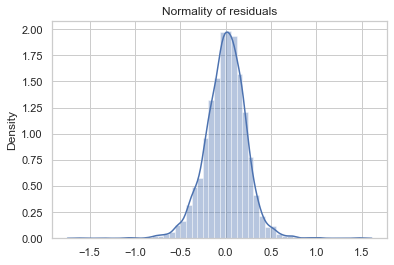

In [95]:
sns.distplot(residual)
plt.title("Normality of residuals")
plt.show()

* Observing a perfect normal distribution of residuals.

**QQ plot of residuals**

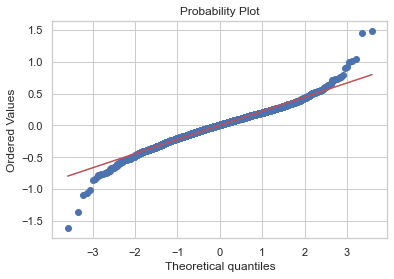

In [96]:
import pylab
import scipy.stats as stats

stats.probplot(residual, dist="norm", plot=pylab)
plt.show()

* The QQ plot of residuals can be used to visually check the normality assumption. The normal probability plot of residuals should **approximately** follow a straight line.

<H3>Applying the shapiro test</H3>

In [97]:
stats.shapiro(residual)

ShapiroResult(statistic=0.9782537817955017, pvalue=6.659765414444679e-25)

* The residuals are not normal as per shapiro test, but as per QQ plot they are approximately normal.

<h3>Test for Homoscedasticity</h3>

In [98]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residual, X_train5)
lzip(name, test)

[('F statistic', 0.9819016432244873), ('p-value', 0.6608236605998665)]

* Since p-value > 0.05, we can say that the residuals are homoscedastic. This assumption is therefore valid.
* Now that all the assumptions are checked and satisfied we can work on the prediction step.

<h3>Predicting on the test data</h3>

In [99]:
X_train12.columns

Index(['const', 'Year', 'Kilometers_Driven', 'Mileage', 'Power',
       'Owner_Type_Second', 'Owner_Type_Third', 'Fuel_Type_Electric',
       'Fuel_Type_LPG', 'Fuel_Type_Petrol', 'Transmission_Manual',
       'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore',
       'Location_Delhi', 'Location_Hyderabad', 'Location_Kolkata', 'Make_Audi',
       'Make_BMW', 'Make_Bentley', 'Make_Chevrolet', 'Make_Datsun',
       'Make_Fiat', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Jaguar',
       'Make_Lamborghini', 'Make_Land', 'Make_Mahindra', 'Make_Mercedes-Benz',
       'Make_Mini', 'Make_Mitsubishi', 'Make_Porsche', 'Make_Renault',
       'Make_Smart', 'Make_Tata', 'Make_Toyota', 'Make_Volkswagen',
       'Make_Volvo'],
      dtype='object')

In [100]:
# Selecting columns from test data that we used to create our final model
X_test_final = X_test[X_train12.columns]

In [101]:
X_test_final.head(5)

,const,Year,Kilometers_Driven,Mileage,Power,Owner_Type_Second,Owner_Type_Third,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Kolkata,Make_Audi,Make_BMW,Make_Bentley,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Ford,Make_Honda,Make_Hyundai,Make_Jaguar,Make_Lamborghini,Make_Land,Make_Mahindra,Make_Mercedes-Benz,Make_Mini,Make_Mitsubishi,Make_Porsche,Make_Renault,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo
2868,1.0,2013,11.141862,23.4,4.304065,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5924,1.0,2017,10.193953,15.4,4.787492,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3764,1.0,2014,11.362103,15.1,4.941642,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4144,1.0,2016,10.858999,25.0,4.234251,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2780,1.0,2009,11.512925,0.0,4.581902,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [102]:
# Checking model performance on train set (seen 70% data)
print("Train Performance\n")
model_perf_OLS(olsres11, X_train12.values, y_train)

Train Performance



,MAE,MAPE,RMSE,R^2,AR^2
0,0.170342,inf,0.224743,0.932882,0.932287


In [103]:
# Checking model performance on test set (seen 70% data)
print("Test Performance\n")
model_perf_OLS(olsres11, X_test_final.values, y_test)

Test Performance



,MAE,MAPE,RMSE,R^2,AR^2
0,0.182319,inf,0.258414,0.915487,0.932287


**Findings:** 
* The model has low test RMSE and MAE and both the errors are comparable and this shows the choosen model is not suffering from overfitting.
* The model is able to explain 93.2% of the variation on the test set using AR^2, which is very good.
* MAE indicates that the current model is able to predict price within a mean error of 0.18 Lakh on the test data.

<h2>Summary of chosen model - olsres11</h2>

In [104]:
olsmod11 = sm.OLS(y_train, X_train12)
olsres11 = olsmod11.fit()
print(olsres11.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1568.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        18:45:15   Log-Likelihood:                 311.17
No. Observations:                4213   AIC:                            -546.3
Df Residuals:                    4175   BIC:                            -305.2
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -238.6147    

<h2>Summary of Findinds and Recommendations</h2>

**Summary of Findings**

* olsres11 is the final model which passed on all the assumptions tested.

* Customers prefer by a large margin manual transmissions over automatic.

* Automatic Cars cost way more more than manual transmission cars.

* Maruti, Hyundai, Honda and Toyota are the top selling vehicles.

* Mumbai, Hyderabad and Kochi are the location with highest volume of sales.

* Chennai, Jaipur, Bangalore and Ahmedabad are the locations with the lowest volume of sales.

* Almedabad, Jaipur, Kolkata, Chennai have the lowest sales revenue.

* Manual transmission has the highest sales revenue in Jaipur and Kolkata.

* Coimbatore, Mumbai and Kochi have the highest revenue and automatic transmissions generating most of the revenue.

* Customers prefer First and Second Handed vehicles

* Customers tend to purchase cars in the 2-9 years old range.

* There is good demand for third, fourth and above pre-owned vehicles.

* Car Prices reduce with the increase in mileage.

* Car Prices increase on vehicles with more power, engine CCs.

* Only a low percentage of buyers can afford luxury cars.

**Recommendations:**

* Based on the observations, it is recommended that Cars4U expand sales and inventory levels in locations with the lowest sales volume as Almedabad, Jaipur, Kolkata, Chennai and promote the business using advertising in these markets.

* Increase the inventory levels of manual transmission cars in Jaipur and Kolkata.

* The model presented is able to predict with 93% of accuracy in pricing pre-owned vehicles with an average error of ~0.18 Lakh.